# Exploratory Temporal Analysis

*Marcos Martínez*

---

Exploratory analysis of the temporal behavior of Networld

***Module Import***

In [1]:
import os
import networkx as nx
import matplotlib.pyplot as plt

from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler

from matlab_utils import *

## 1. Network Collapse

Simulaciones que paran cuando  todos los nodos colapsan en una sola red (or cuando se alcanza un maximo de pasos)

***Load Data***

In [30]:
data_path = '../data/'
data_files = os.listdir(data_path)
data_files = [file for file in data_files if file.split('_')[0] == 'PROCESSED' and file.split('_')[3] == 'TMax5000']

In [32]:
data = {}

for file in data_files:
    info = file.split('_')
    beta = float(info[2][4:])
    rep = int(info[-1].split('.')[0][3:])
    file = data_path + file
    sim_data = load_processed_networld(file)
    meas_data = sim_data['Networks_Time'].merge(sim_data['Networks_Measures'], how='left', on='NRed')
    meas_data['Rep'] = rep
    if beta in data.keys():
        data[beta].append(meas_data)
    else:
        data[beta] = [meas_data]

In [33]:
for beta in data.keys():
    data[beta] = pd.concat(data[beta]).reset_index(drop=True)

#### 2.1.1 Analysis of trayectories

***Number of Networks***

In [34]:
num_net_data = {}

for i, beta in enumerate(sorted(data.keys())):
    beta_num_net = data[beta].groupby(['t','Rep'])['NRep'].sum().reset_index()
    num_net_data[beta] = beta_num_net

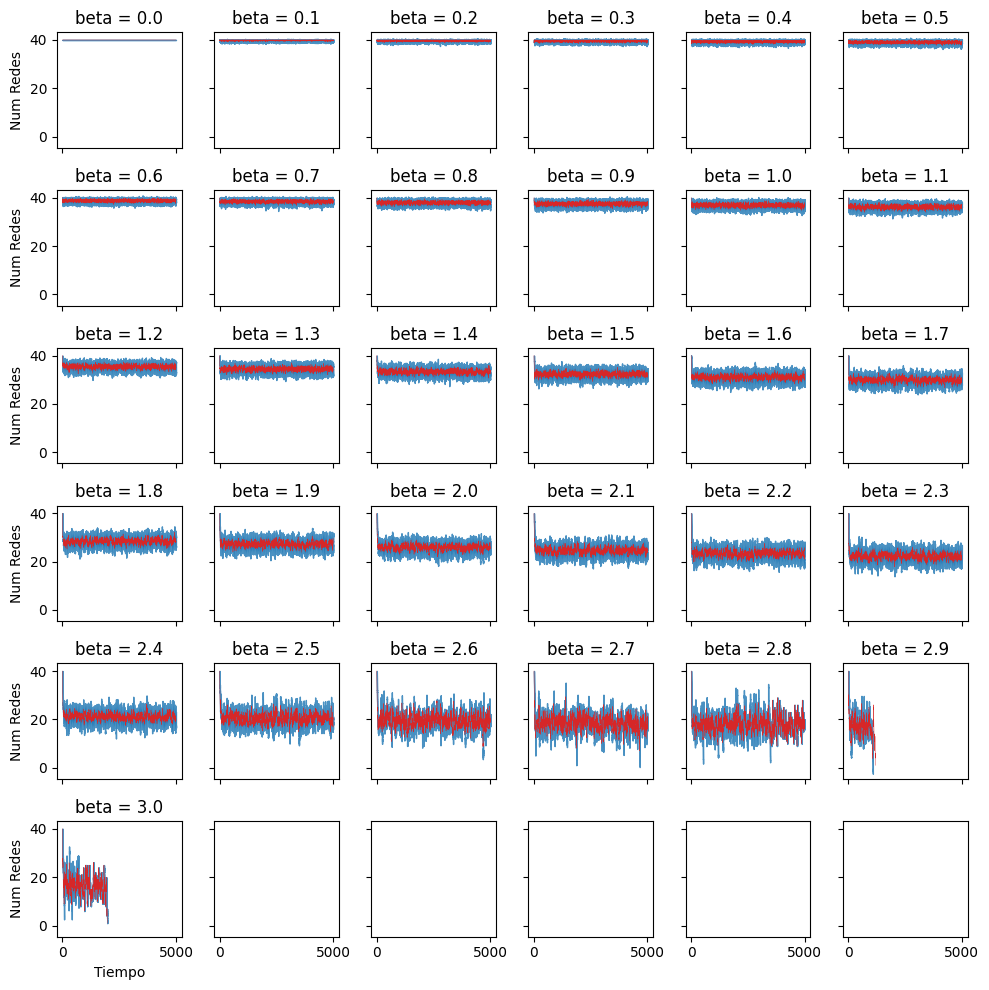

In [38]:
fig, axs = plt.subplots(6,6, sharex='all', sharey='all', figsize=(10,10))
axs = [ax for axlist in axs for ax in axlist]

for i, beta in enumerate(sorted(num_net_data.keys())):
    mean = num_net_data[beta].groupby('t')['NRep'].mean().reset_index()
    std = num_net_data[beta].groupby('t')['NRep'].std().reset_index()
    axs[i].fill_between(std['t'], mean['NRep']-std['NRep'], mean['NRep']+std['NRep'], alpha=0.8, color='tab:blue')
    mean.plot(x='t', y='NRep', ax=axs[i], color='tab:red', legend=False, lw=0.3)
    axs[i].set_title(f'beta = {beta}')
    axs[i].set_xlabel('Tiempo')
    axs[i].set_ylabel('Num Redes')
fig.tight_layout()

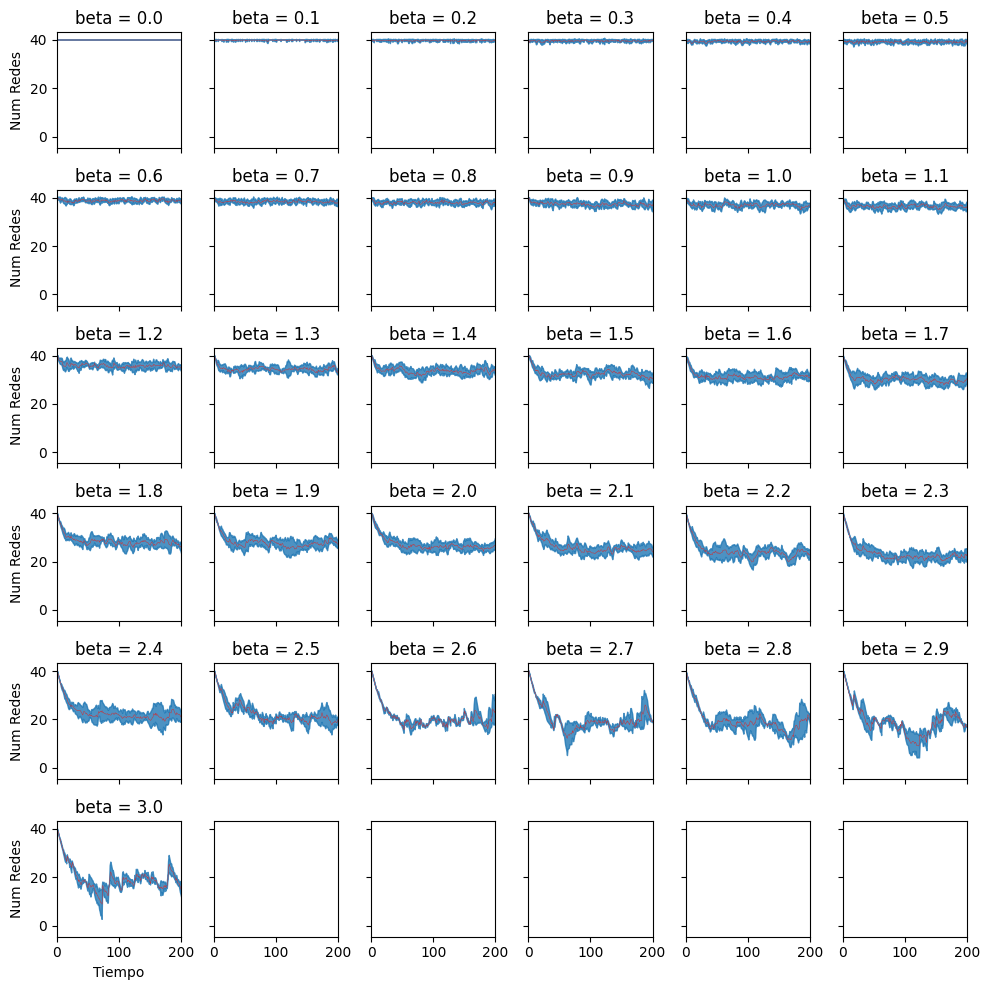

In [39]:
fig, axs = plt.subplots(6,6, sharex='all', sharey='all', figsize=(10,10))
axs = [ax for axlist in axs for ax in axlist]

for i, beta in enumerate(sorted(num_net_data.keys())):
    mean = num_net_data[beta].groupby('t')['NRep'].mean().reset_index()
    std = num_net_data[beta].groupby('t')['NRep'].std().reset_index()
    axs[i].fill_between(std['t'], mean['NRep']-std['NRep'], mean['NRep']+std['NRep'], alpha=0.8, color='tab:blue')
    mean.plot(x='t', y='NRep', ax=axs[i], color='tab:red', legend=False, lw=0.3)
    axs[i].set_title(f'beta = {beta}')
    axs[i].set_xlabel('Tiempo')
    axs[i].set_ylabel('Num Redes')
    axs[i].set_xlim(0,200)
fig.tight_layout()

Proceso estocástico donde se produce:
1. Un descenso rápido del número de redes
2. Un estado estacionario que depende de beta (beta=1.2 ~ 35; beta=2.8 ~20)
3. Para betas suficientemente altos se produce un segundo descenso rápido cuando colapsan todos los nodos en una sola red 


***Diversity of Networks***

Entropía (sin normalizar) de la distribucion de redes que hay en cada instante temporal (X repeticiones de la red 0, Y de la red 1, ...)

In [40]:
diversity_data = {}

for i, beta in enumerate(sorted(data.keys())):
    beta_diversity = data[beta]
    beta_diversity['NNet'] = beta_diversity.groupby(['t','Rep'])['NRep'].transform('sum')
    beta_diversity['p'] = beta_diversity['NRep'] / beta_diversity['NNet']
    beta_diversity = beta_diversity.groupby(['t','Rep'])['p'].aggregate(entropy).reset_index()
    beta_diversity.rename(columns={'p':'Diversity'}, inplace=True)
    diversity_data[beta] = beta_diversity

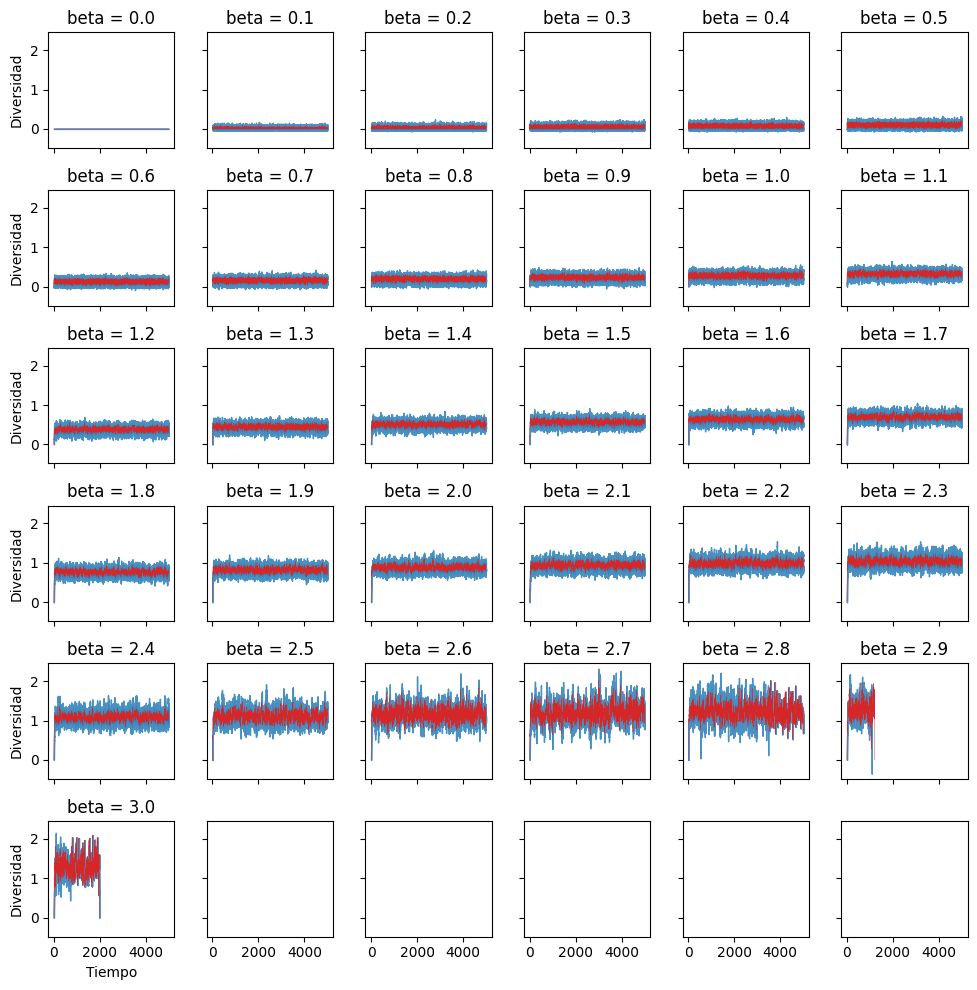

In [43]:
fig, axs = plt.subplots(6,6, sharex='all', sharey='all', figsize=(10,10))
axs = [ax for axlist in axs for ax in axlist]

for i, beta in enumerate(sorted(diversity_data.keys())):
    mean = diversity_data[beta].groupby('t')['Diversity'].mean().reset_index()
    std = diversity_data[beta].groupby('t')['Diversity'].std().reset_index()
    axs[i].fill_between(std['t'], mean['Diversity']-std['Diversity'], mean['Diversity']+std['Diversity'], alpha=0.8, color='tab:blue')
    mean.plot(x='t', y='Diversity', ax=axs[i], color='tab:red', legend=False, lw=0.3)
    axs[i].set_title(f'beta = {beta}')
    axs[i].set_xlabel('Tiempo')
    axs[i].set_ylabel('Diversidad')
fig.tight_layout()

Comportamiento similar al anterior pero la diversidad empieza en 0 (todos son nodos simples) y colapsa de vuelta a 0 cuando se unen todos los nodos

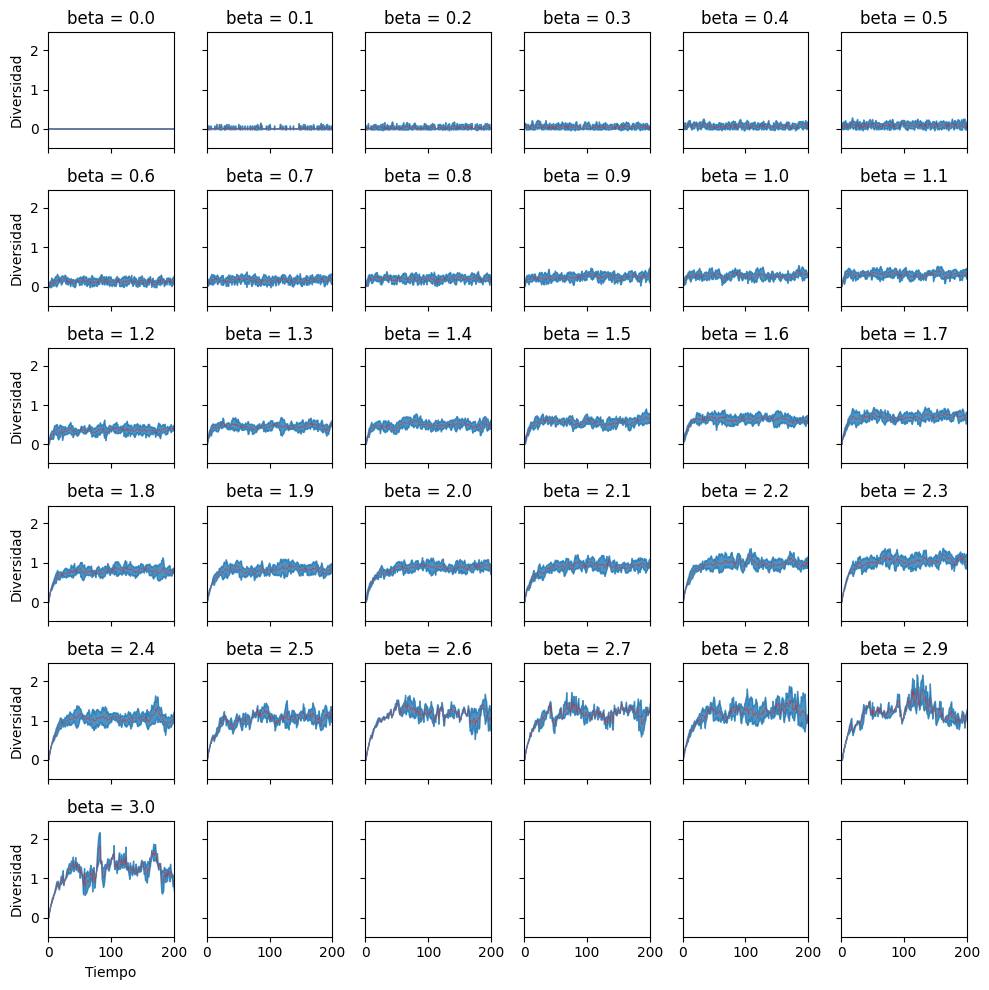

In [44]:
fig, axs = plt.subplots(6,6, sharex='all', sharey='all', figsize=(10,10))
axs = [ax for axlist in axs for ax in axlist]

for i, beta in enumerate(sorted(diversity_data.keys())):
    mean = diversity_data[beta].groupby('t')['Diversity'].mean().reset_index()
    std = diversity_data[beta].groupby('t')['Diversity'].std().reset_index()
    axs[i].fill_between(std['t'], mean['Diversity']-std['Diversity'], mean['Diversity']+std['Diversity'], alpha=0.8, color='tab:blue')
    mean.plot(x='t', y='Diversity', ax=axs[i], color='tab:red', legend=False, lw=0.3)
    axs[i].set_title(f'beta = {beta}')
    axs[i].set_xlabel('Tiempo')
    axs[i].set_ylabel('Diversidad')
    axs[i].set_xlim(0,200)
fig.tight_layout()

***$\lambda_1$ of Networks***

In [8]:
lamb1_data = {}

for i, beta in enumerate(sorted(data.keys())):
    beta_lamb1 = []
    for sim_data in data[beta]:
        df_cp = sim_data[['t','NRep','Lamb1','NNet']].copy()
        df_cp['Lamb1'] = df_cp['Lamb1']*df_cp['NRep'] / df_cp['NNet']
        lamb1 = df_cp.groupby('t')['Lamb1'].sum().reset_index()
        beta_lamb1.append(lamb1)
    lamb1_data[beta] = beta_lamb1

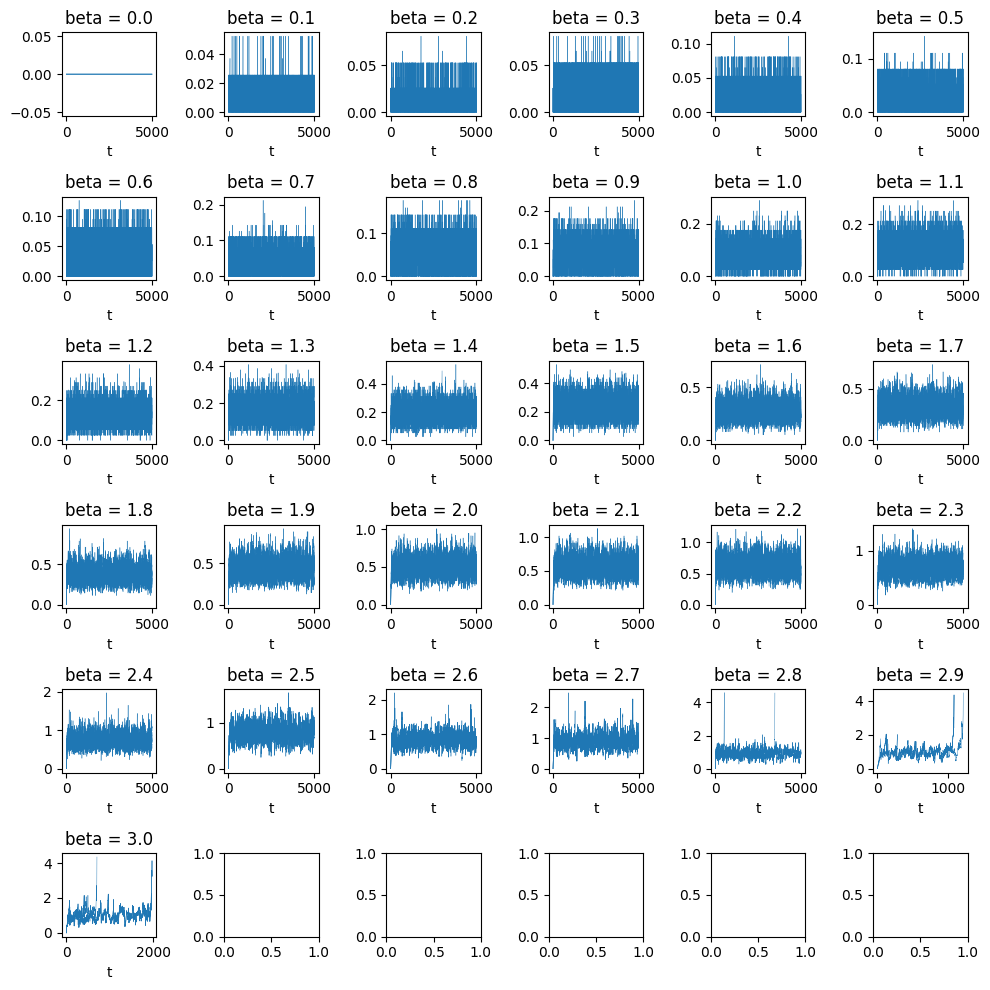

In [26]:
fig, axs = plt.subplots(6,6, figsize=(10,10))
axs = [ax for axlist in axs for ax in axlist]

for i, beta in enumerate(sorted(lamb1_data.keys())):
    for lamb1 in lamb1_data[beta]:
        lamb1.plot(x='t', y='Lamb1', ax=axs[i], color='tab:blue', legend=False, lw=0.3)
        axs[i].set_title(f'beta = {beta}')
fig.tight_layout()

Similar a las medidas anteriores pero con el punto inicial de baja estabilidad y el punto final de alta estabilidad.

***$\lambda_2$ of Networks***

In [9]:
lamb2_data = {}

for i, beta in enumerate(sorted(data.keys())):
    beta_lamb2 = []
    for sim_data in data[beta]:
        df_cp = sim_data[['t','NRep','Lamb2','NNet']].copy()
        df_cp['Lamb2'] = df_cp['Lamb2']*df_cp['NRep'] / df_cp['NNet']
        lamb2 = df_cp.groupby('t')['Lamb2'].sum().reset_index()
        beta_lamb2.append(lamb2)
    lamb2_data[beta] = beta_lamb2

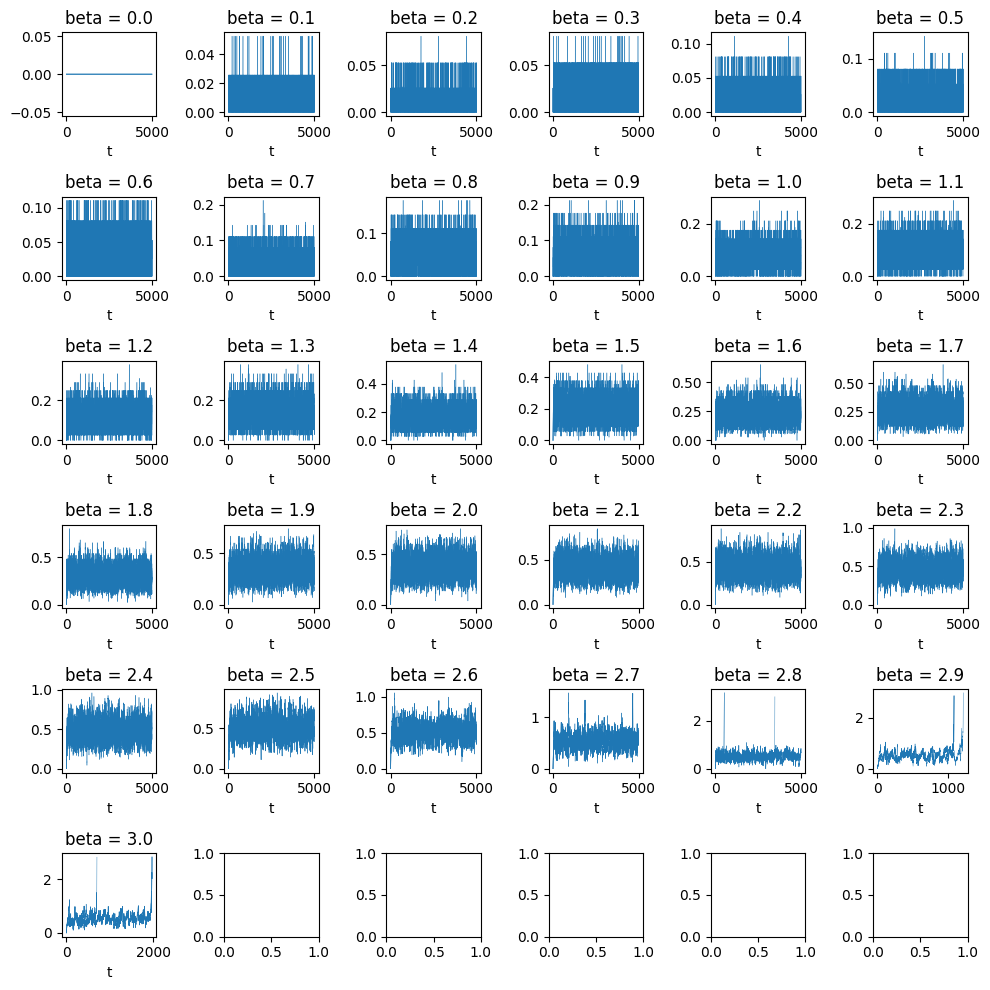

In [28]:
fig, axs = plt.subplots(6,6, figsize=(10,10))
axs = [ax for axlist in axs for ax in axlist]

for i, beta in enumerate(sorted(lamb2_data.keys())):
    for lamb2 in lamb2_data[beta]:
        lamb2.plot(x='t', y='Lamb2', ax=axs[i], color='tab:blue', legend=False, lw=0.3)
        axs[i].set_title(f'beta = {beta}')
fig.tight_layout()

Similar a Lambda 1

***H of Networks***

In [10]:
f_cp['NRep'] / df_cp['NNet']
        lamb1 = df_cp.groupby('t')['Lamb1'].sum().reset_index()H_data = {}

for i, beta in enumerate(sorted(data.keys())):
    beta_H = []
    for sim_data in data[beta]:
        df_cp = sim_data[['t','NRep','H','NNet']].copy()
        df_cp['H'] = df_cp['H']*df_cp['NRep'] / df_cp['NNet']
        H = df_cp.groupby('t')['H'].sum().reset_index()
        beta_H.append(H)
    H_data[beta] = beta_H

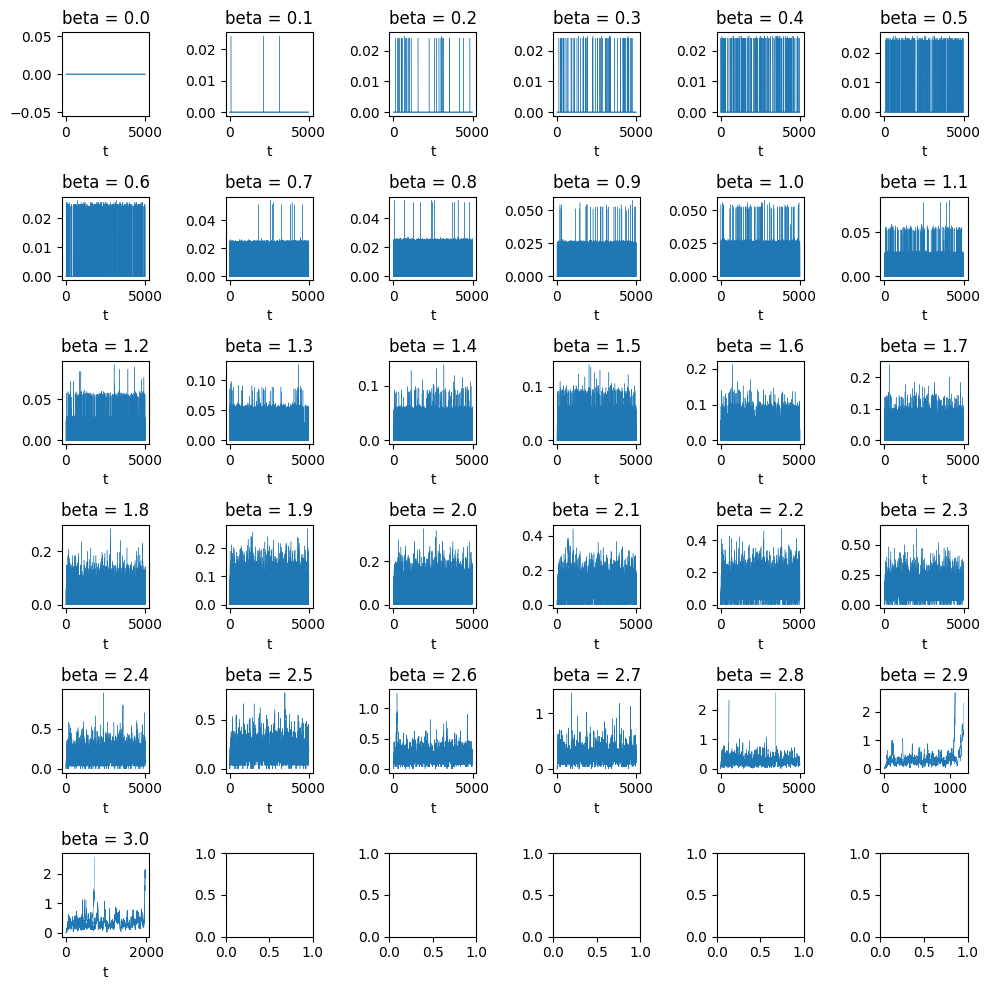

In [30]:
fig, axs = plt.subplots(6,6, figsize=(10,10))
axs = [ax for axlist in axs for ax in axlist]

for i, beta in enumerate(sorted(H_data.keys())):
    for H in H_data[beta]:
        H.plot(x='t', y='H', ax=axs[i], color='tab:blue', legend=False, lw=0.3)
        axs[i].set_title(f'beta = {beta}')
fig.tight_layout()

Similar a los Lambda

***Mean Degree of Networks***

In [46]:
GrMedio_data = {}

for i, beta in enumerate(sorted(data.keys())):
    df_cp = data[beta][['t','NRep','GrMedio','NNet','Rep']].copy()
    df_cp['GrMedio'] = df_cp['GrMedio'] * df_cp['NRep'] / df_cp['NNet']
    beta_GrMedio = df_cp.groupby(['t','GrMedio']).sum().reset_index()
    GrMedio_data[beta] = beta_GrMedio

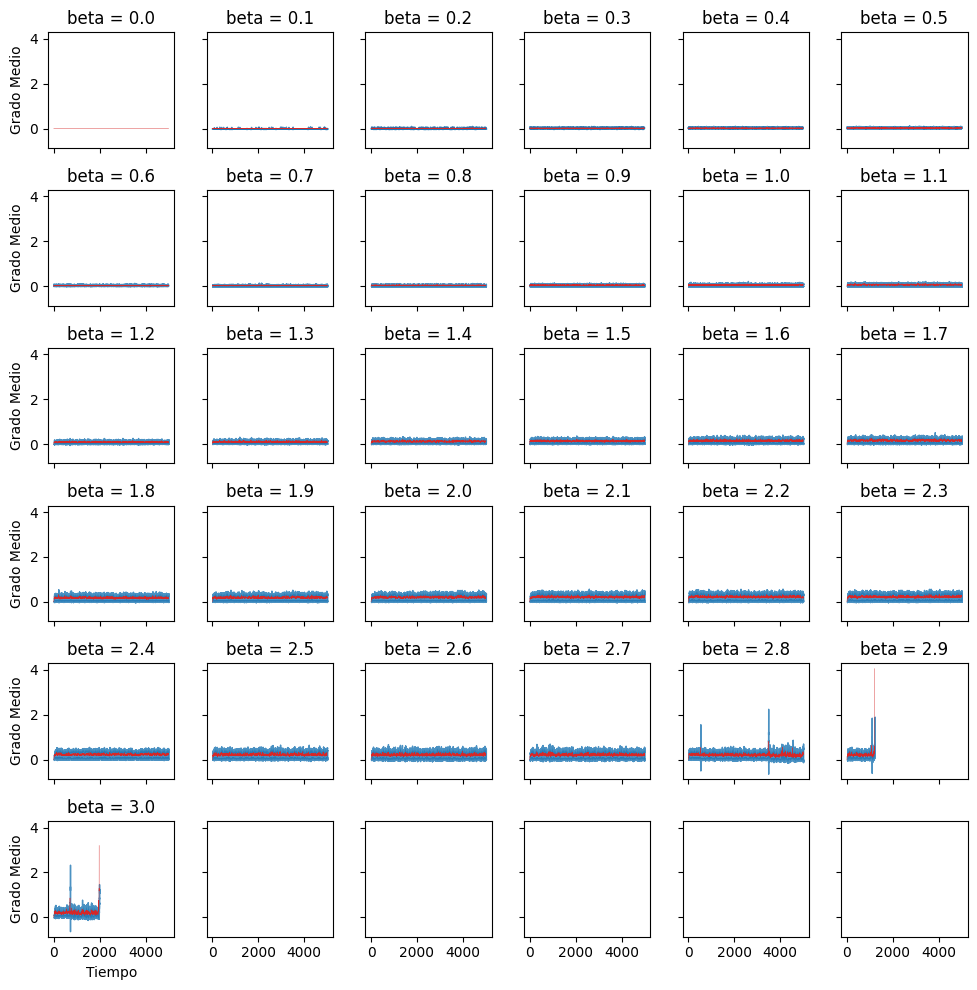

In [48]:
fig, axs = plt.subplots(6,6, sharex='all', sharey='all', figsize=(10,10))
axs = [ax for axlist in axs for ax in axlist]

for i, beta in enumerate(sorted(GrMedio_data.keys())):
    mean = GrMedio_data[beta].groupby('t')['GrMedio'].mean().reset_index()
    std = GrMedio_data[beta].groupby('t')['GrMedio'].std().reset_index()
    axs[i].fill_between(std['t'], mean['GrMedio']-std['GrMedio'], mean['GrMedio']+std['GrMedio'], alpha=0.8, color='tab:blue')
    mean.plot(x='t', y='GrMedio', ax=axs[i], color='tab:red', legend=False, lw=0.3)
    axs[i].set_title(f'beta = {beta}')
    axs[i].set_xlabel('Tiempo')
    axs[i].set_ylabel('Grado Medio')
fig.tight_layout()

Similar a los lambda y H

***Abundance of Networks***

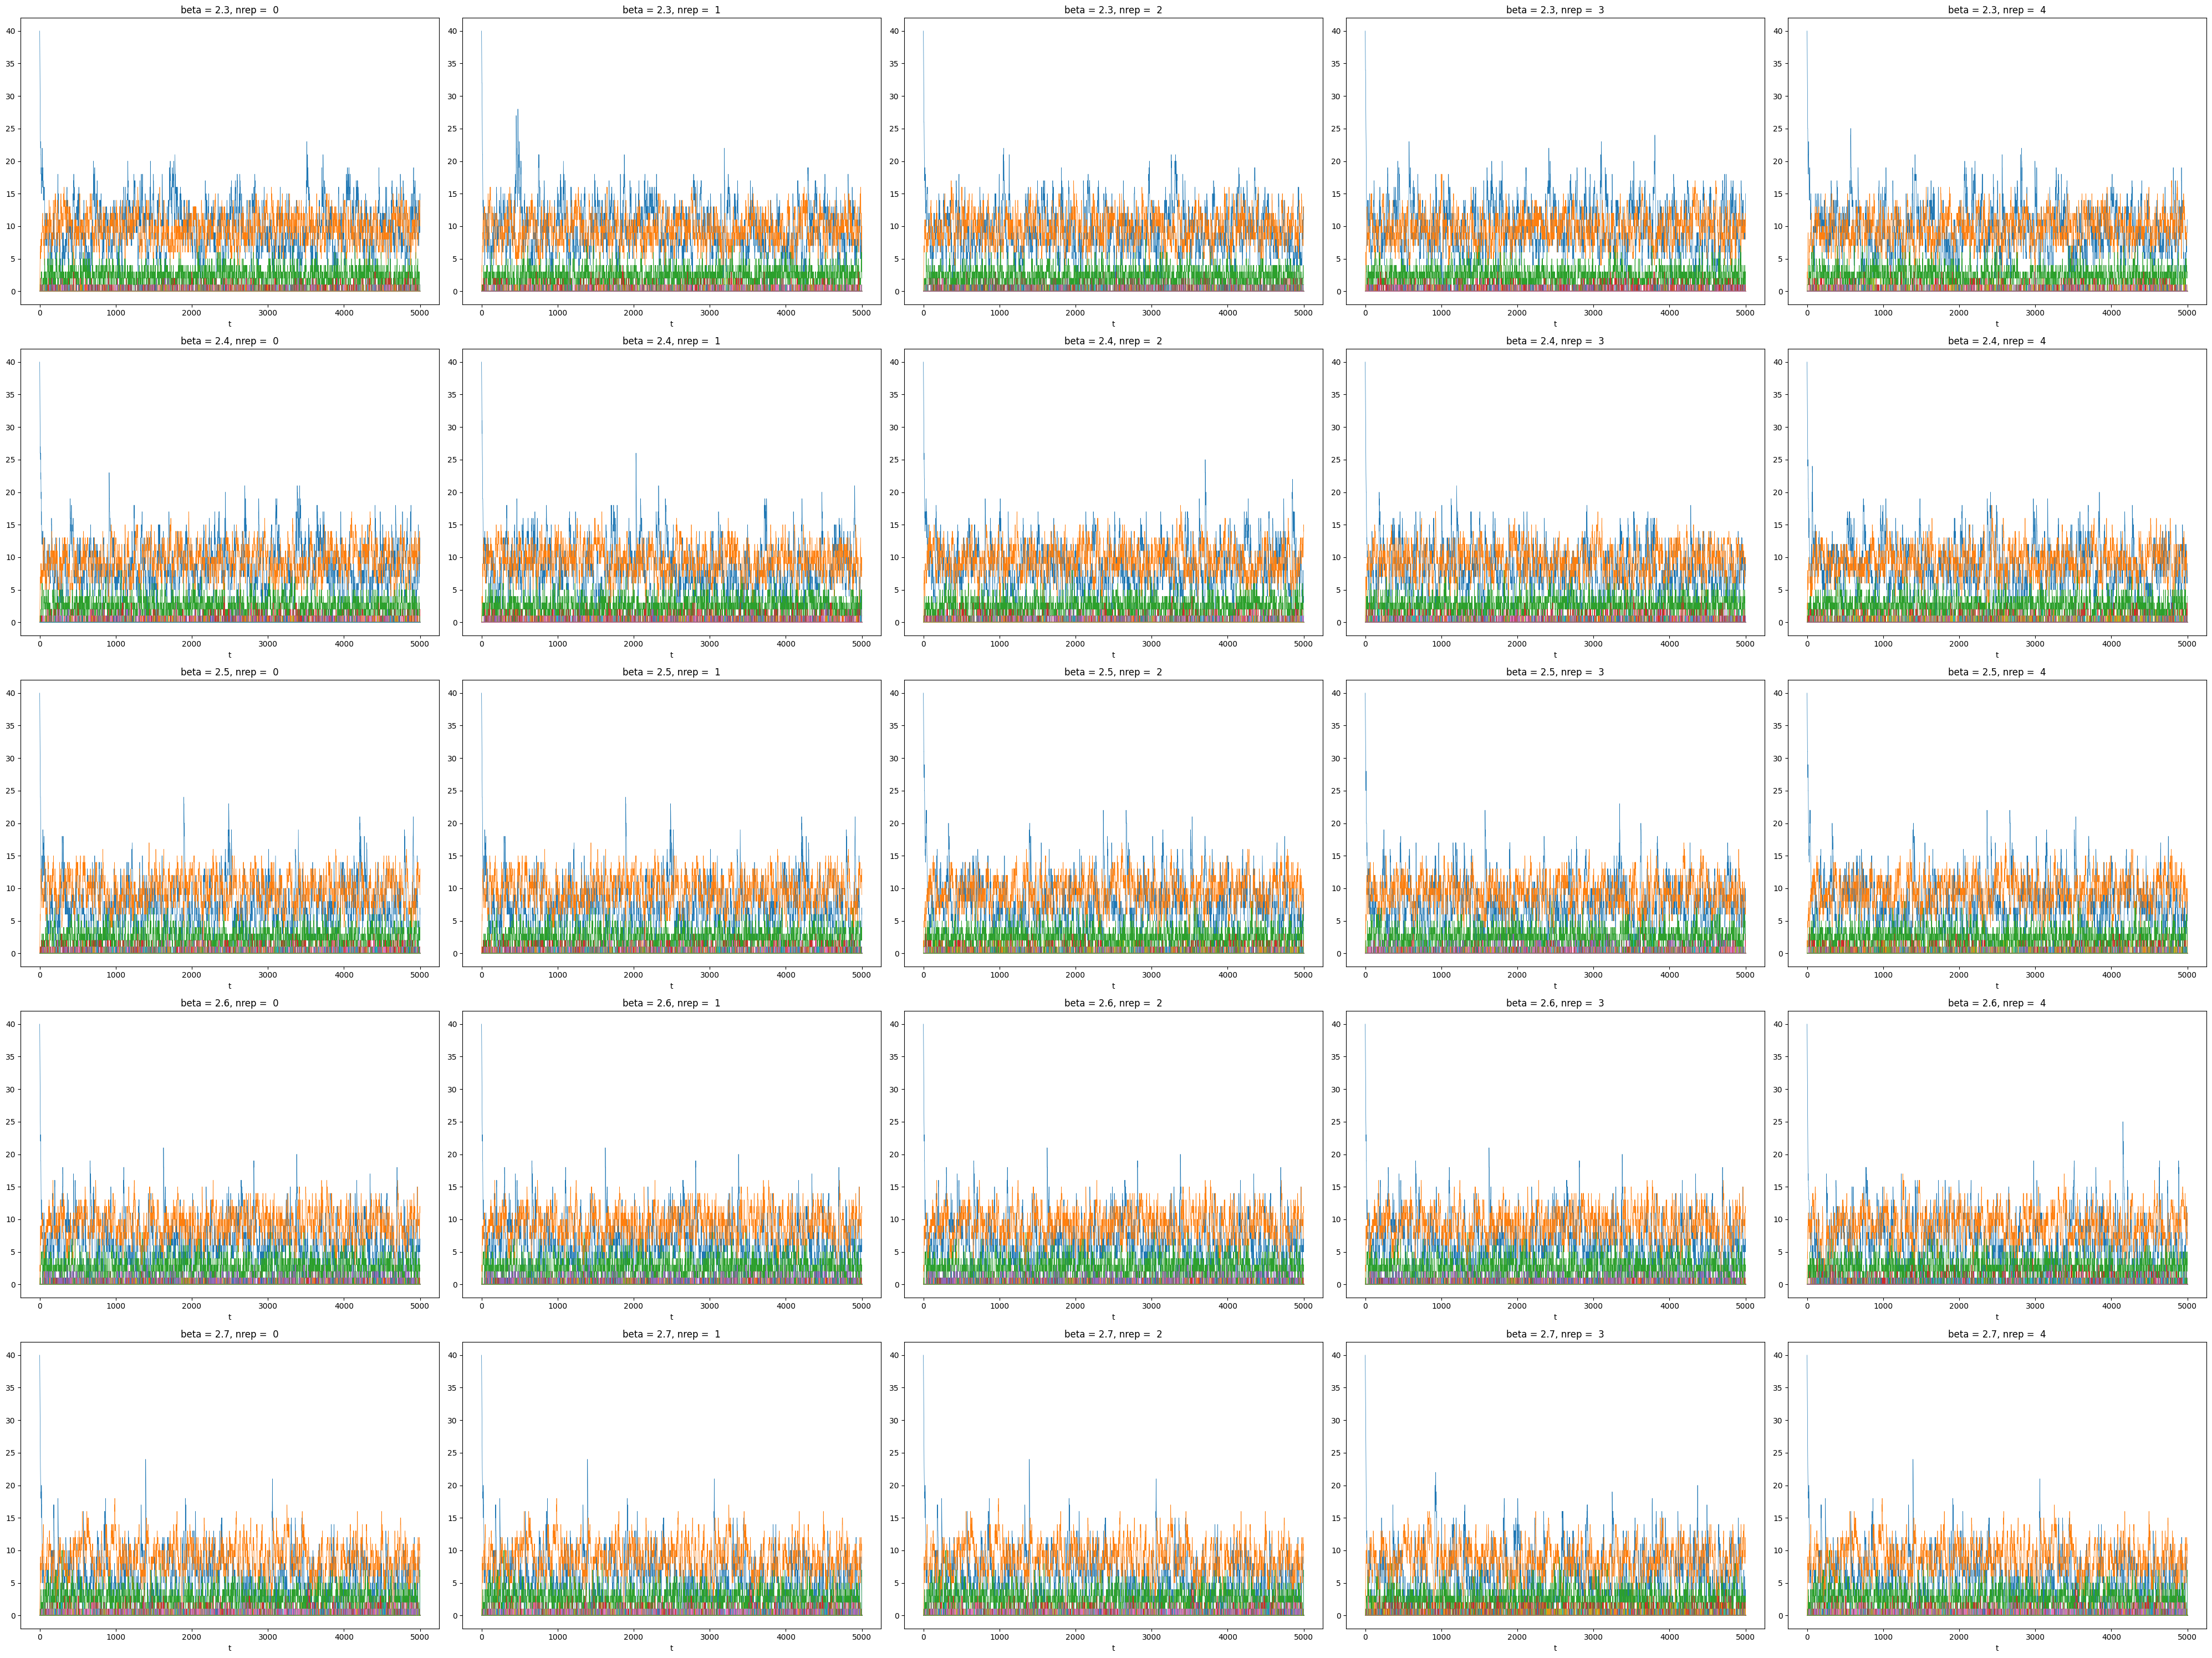

In [33]:
fig, axs = plt.subplots(5,5, figsize=(40,30))

for i, beta in enumerate(list(sorted(data.keys()))[23:28]):
    for nrep in range(5):
        plot_data = data[beta][nrep][['t','NRed','NRep']]
        plot_data = plot_data.pivot(index='t', columns='NRed', values='NRep')
        plot_data = plot_data.fillna(0).reset_index()
        plot_data.plot(x='t', legend=False, ax=axs[i][nrep], lw=0.5)
        axs[i][nrep].set_title(f'beta = {beta}, nrep =  {nrep}')
fig.tight_layout()

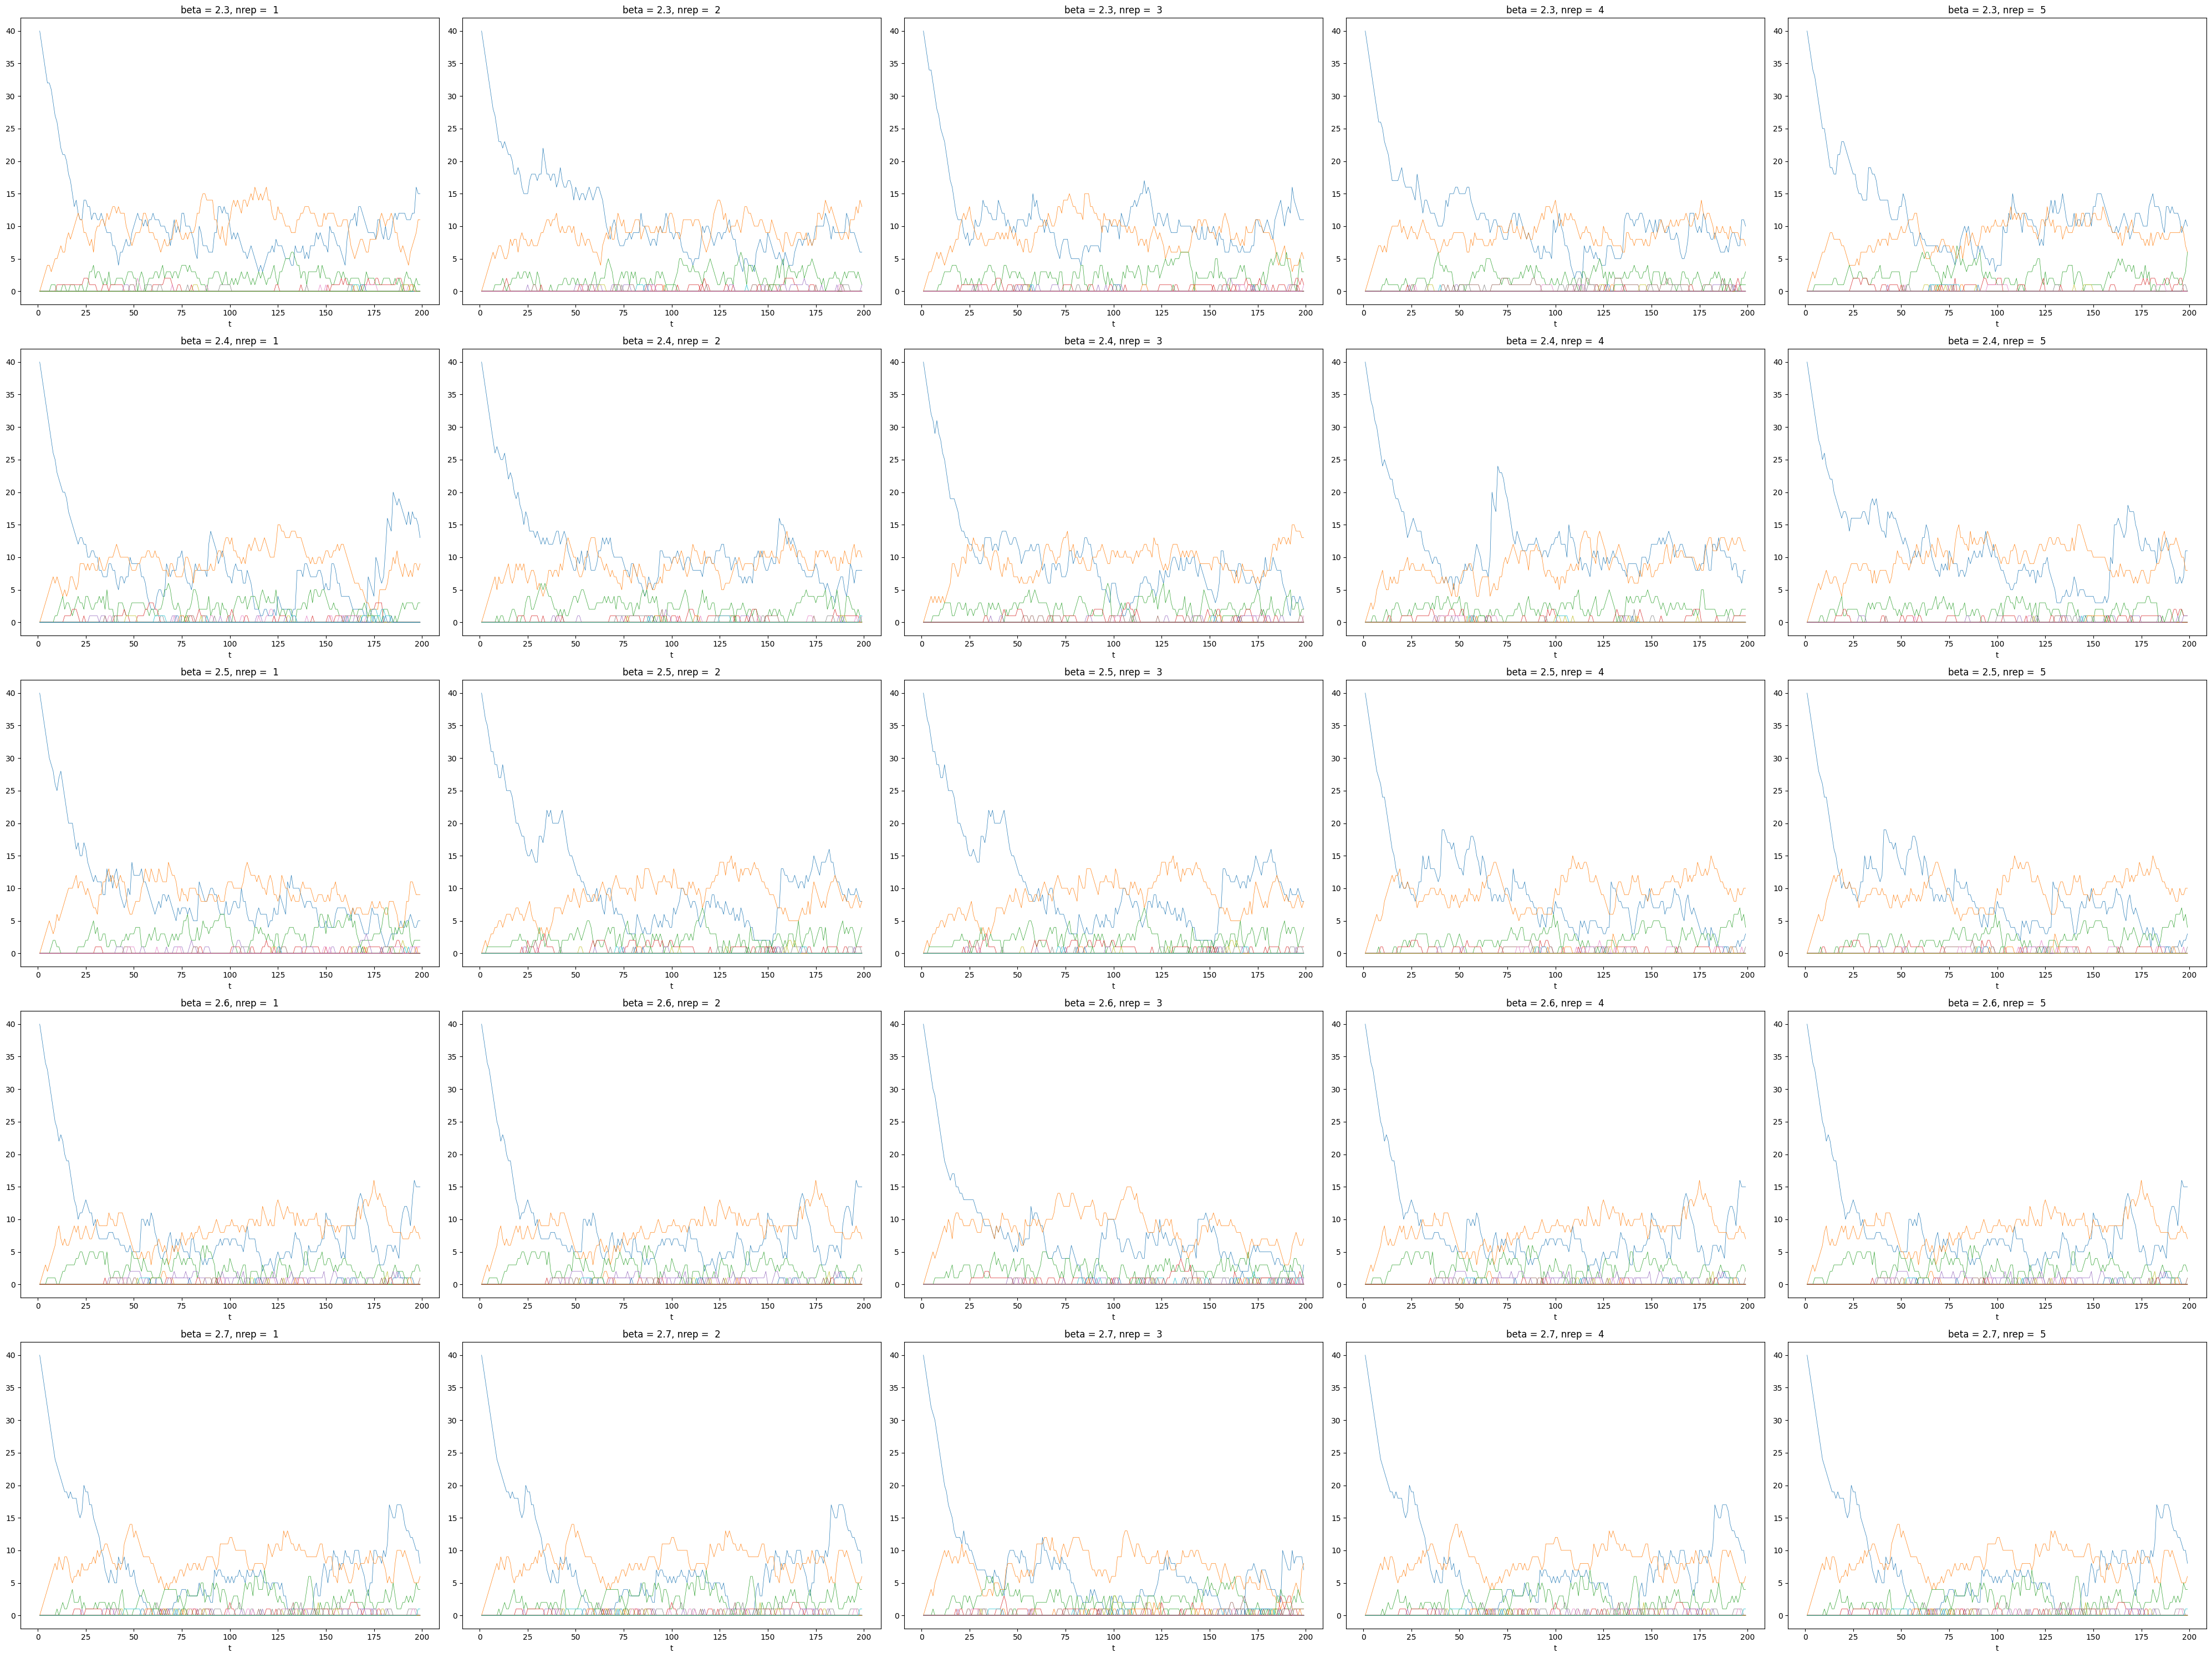

In [55]:
fig, axs = plt.subplots(5,5, figsize=(40,30))

for i, beta in enumerate(list(sorted(data.keys()))[23:28]):
    for nrep in range(1,6):
        plot_data = data[beta][['t','NRed','NRep', 'Rep']]
        plot_data = plot_data.loc[(plot_data['t']<200) & (plot_data['Rep']==nrep)]
        plot_data = plot_data.pivot(index='t', columns='NRed', values='NRep')
        plot_data = plot_data.fillna(0).reset_index()
        plot_data.plot(x='t', legend=False, ax=axs[i][nrep-1], lw=0.5)
        axs[i][nrep-1].set_title(f'beta = {beta}, nrep =  {nrep}')
fig.tight_layout()

Al hacer zoom en los primeros 200 pasos donde se produce la estabilización se puede ver como las redes principales van alcanzando su estado estacionario (azul=nodo suelto, amarillo=red 2 nodos, verde=red 3 nodos) 

### Multivariable

***$\beta = 2$***

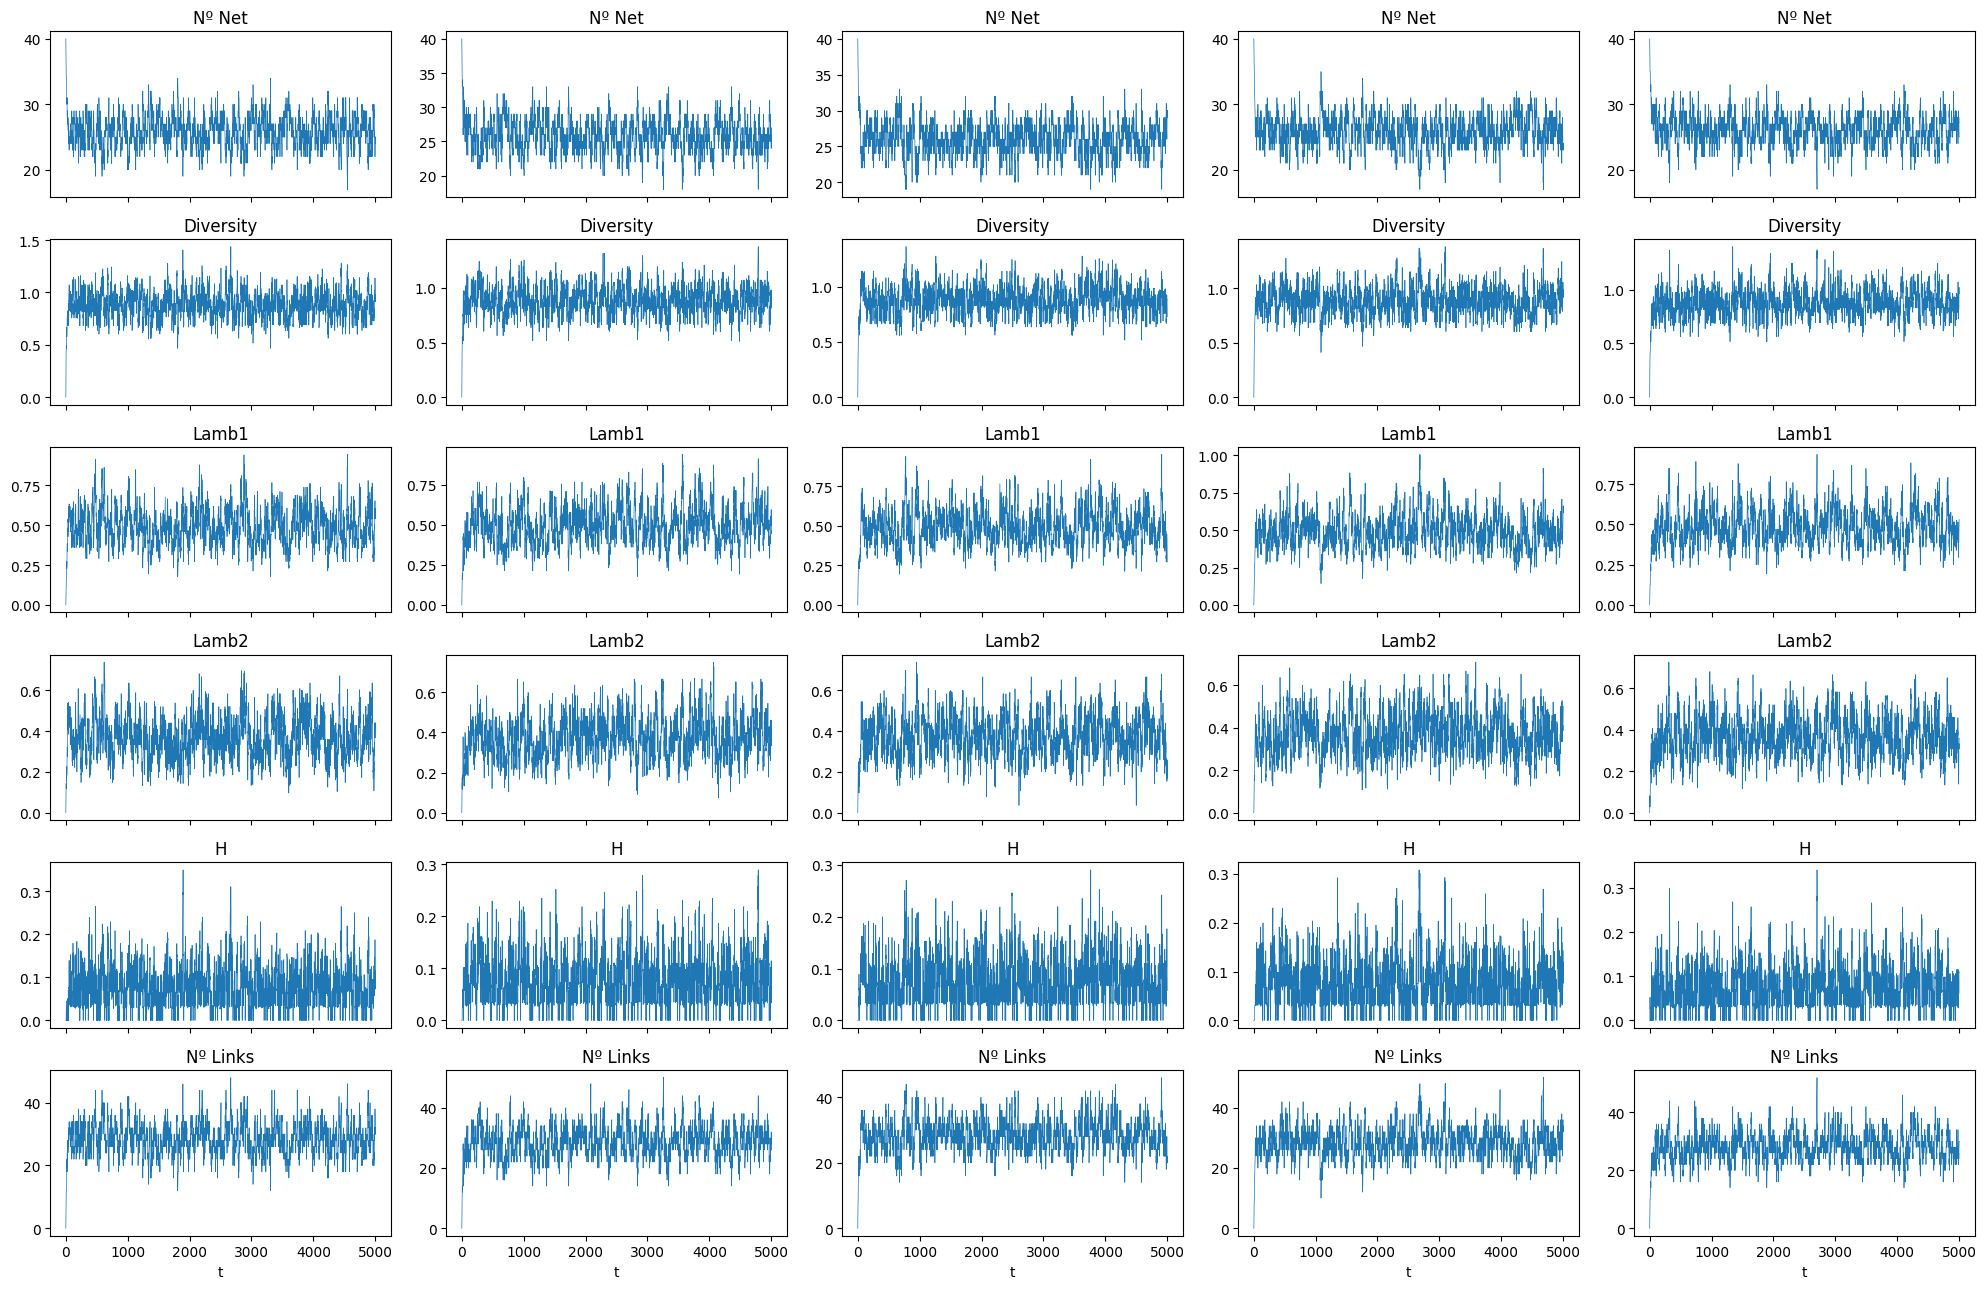

In [12]:
fig, axs = plt.subplots(6,5, figsize=(20,13), sharex=True)

beta = 2

for nrep in range(5):
    num_net_data[beta][nrep].plot(x='t', y='NRep', legend=False, ax=axs[0][nrep], lw=0.5)
    axs[0][nrep].set_title(f'Nº Net')
    diversity_data[beta][nrep].plot(x='t', y='Diversity', legend=False, ax=axs[1][nrep], lw=0.5)
    axs[1][nrep].set_title(f'Diversity')
    lamb1_data[beta][nrep].plot(x='t', y='Lamb1', legend=False, ax=axs[2][nrep], lw=0.5)
    axs[2][nrep].set_title(f'Lamb1')
    lamb2_data[beta][nrep].plot(x='t', y='Lamb2', legend=False, ax=axs[3][nrep], lw=0.5)
    axs[3][nrep].set_title(f'Lamb2')
    H_data[beta][nrep].plot(x='t', y='H', legend=False, ax=axs[4][nrep], lw=0.5)
    axs[4][nrep].set_title(f'H')
    N_Links_data[beta][nrep].plot(x='t', y='N_Links', legend=False, ax=axs[5][nrep], lw=0.5)
    axs[5][nrep].set_title(f'Nº Links')
fig.tight_layout()

Con un beta demasiado bajo parece todo un proceso estocástico plano y sin mucha actividad.

Se debe alcanzar un estado estacionario con una distribución relativamente estable de nodos sueltos, pares y trios, y luego irán apareciendo y desapareciendo algunas redes de unos pocos nodos más

***$\beta = 2.6$***

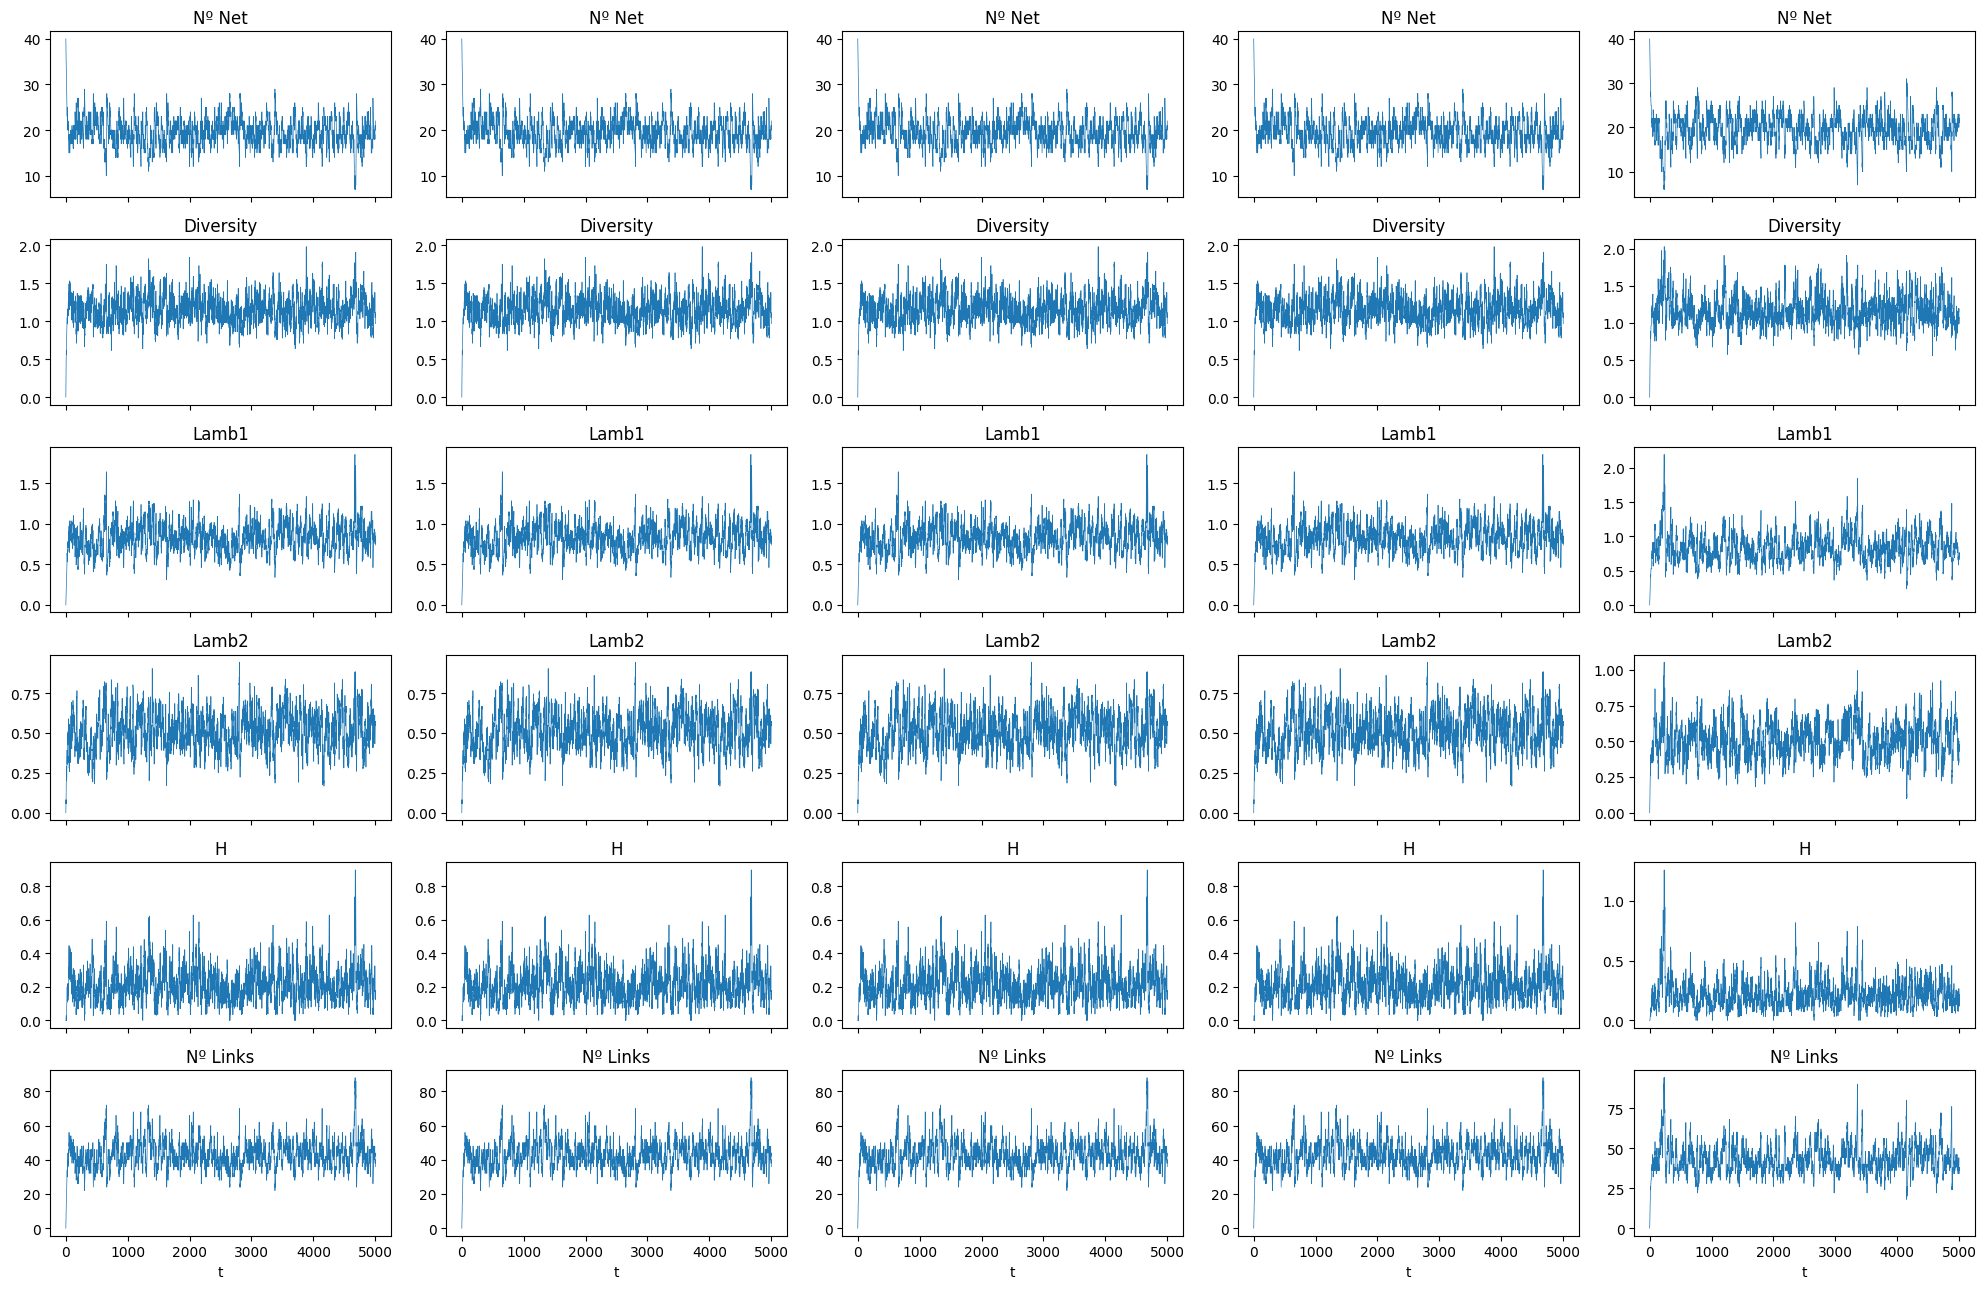

In [13]:
fig, axs = plt.subplots(6,5, figsize=(20,13), sharex=True)

beta = 2.6

for nrep in range(5):
    num_net_data[beta][nrep].plot(x='t', y='NRep', legend=False, ax=axs[0][nrep], lw=0.5)
    axs[0][nrep].set_title(f'Nº Net')
    diversity_data[beta][nrep].plot(x='t', y='Diversity', legend=False, ax=axs[1][nrep], lw=0.5)
    axs[1][nrep].set_title(f'Diversity')
    lamb1_data[beta][nrep].plot(x='t', y='Lamb1', legend=False, ax=axs[2][nrep], lw=0.5)
    axs[2][nrep].set_title(f'Lamb1')
    lamb2_data[beta][nrep].plot(x='t', y='Lamb2', legend=False, ax=axs[3][nrep], lw=0.5)
    axs[3][nrep].set_title(f'Lamb2')
    H_data[beta][nrep].plot(x='t', y='H', legend=False, ax=axs[4][nrep], lw=0.5)
    axs[4][nrep].set_title(f'H')
    N_Links_data[beta][nrep].plot(x='t', y='N_Links', legend=False, ax=axs[5][nrep], lw=0.5)
    axs[5][nrep].set_title(f'Nº Links')
fig.tight_layout()

Con beta un poco más alta... parece haber algún colapso o casi colapso pero tampoco...

***$\beta = 3$***

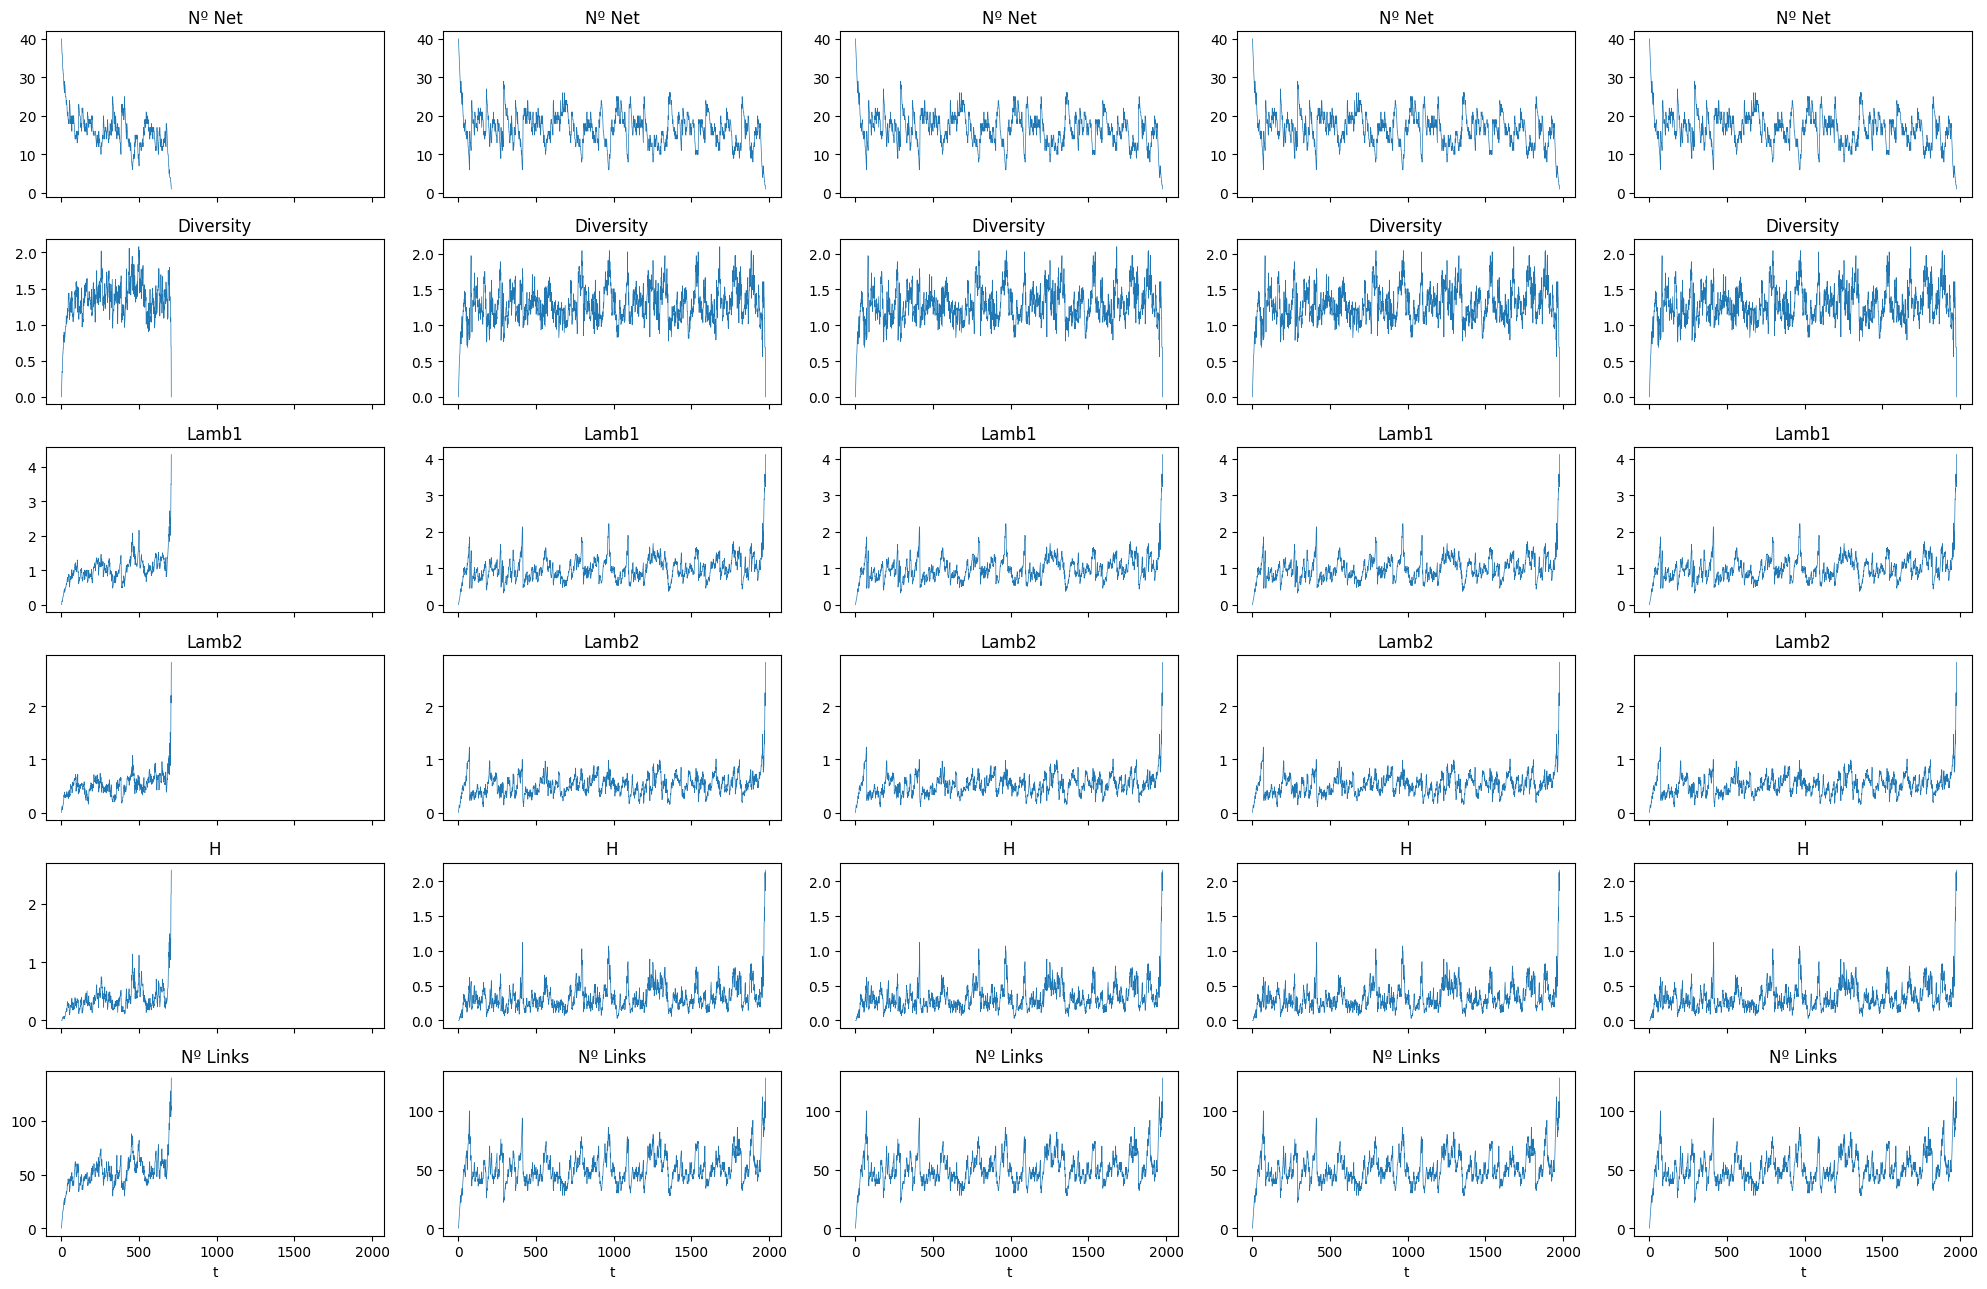

In [14]:
fig, axs = plt.subplots(6,5, figsize=(20,13), sharex=True)

beta = 3

for nrep in range(5):
    num_net_data[beta][nrep].plot(x='t', y='NRep', legend=False, ax=axs[0][nrep], lw=0.5)
    axs[0][nrep].set_title(f'Nº Net')
    diversity_data[beta][nrep].plot(x='t', y='Diversity', legend=False, ax=axs[1][nrep], lw=0.5)
    axs[1][nrep].set_title(f'Diversity')
    lamb1_data[beta][nrep].plot(x='t', y='Lamb1', legend=False, ax=axs[2][nrep], lw=0.5)
    axs[2][nrep].set_title(f'Lamb1')
    lamb2_data[beta][nrep].plot(x='t', y='Lamb2', legend=False, ax=axs[3][nrep], lw=0.5)
    axs[3][nrep].set_title(f'Lamb2')
    H_data[beta][nrep].plot(x='t', y='H', legend=False, ax=axs[4][nrep], lw=0.5)
    axs[4][nrep].set_title(f'H')
    N_Links_data[beta][nrep].plot(x='t', y='N_Links', legend=False, ax=axs[5][nrep], lw=0.5)
    axs[5][nrep].set_title(f'Nº Links')
fig.tight_layout()

Con beta suficientemente alto se observa el colapso a una sola red en general y como coinciden los cambios drásticos en todas las medidas a la vez

### 2.2 Analysis of abundance

***Abundancia por tamaño de red***

In [60]:
size_abundance = {}
for i, beta in enumerate(sorted(data.keys())):
    df_cp = data[beta].copy()
    df_cp.groupby(['t','N','Rep'])['NRep'].sum().reset_index()
    beta_size_abundance = df_cp.groupby(['t','N'])['NRep'].mean().reset_index()
    size_abundance[beta] = beta_size_abundance

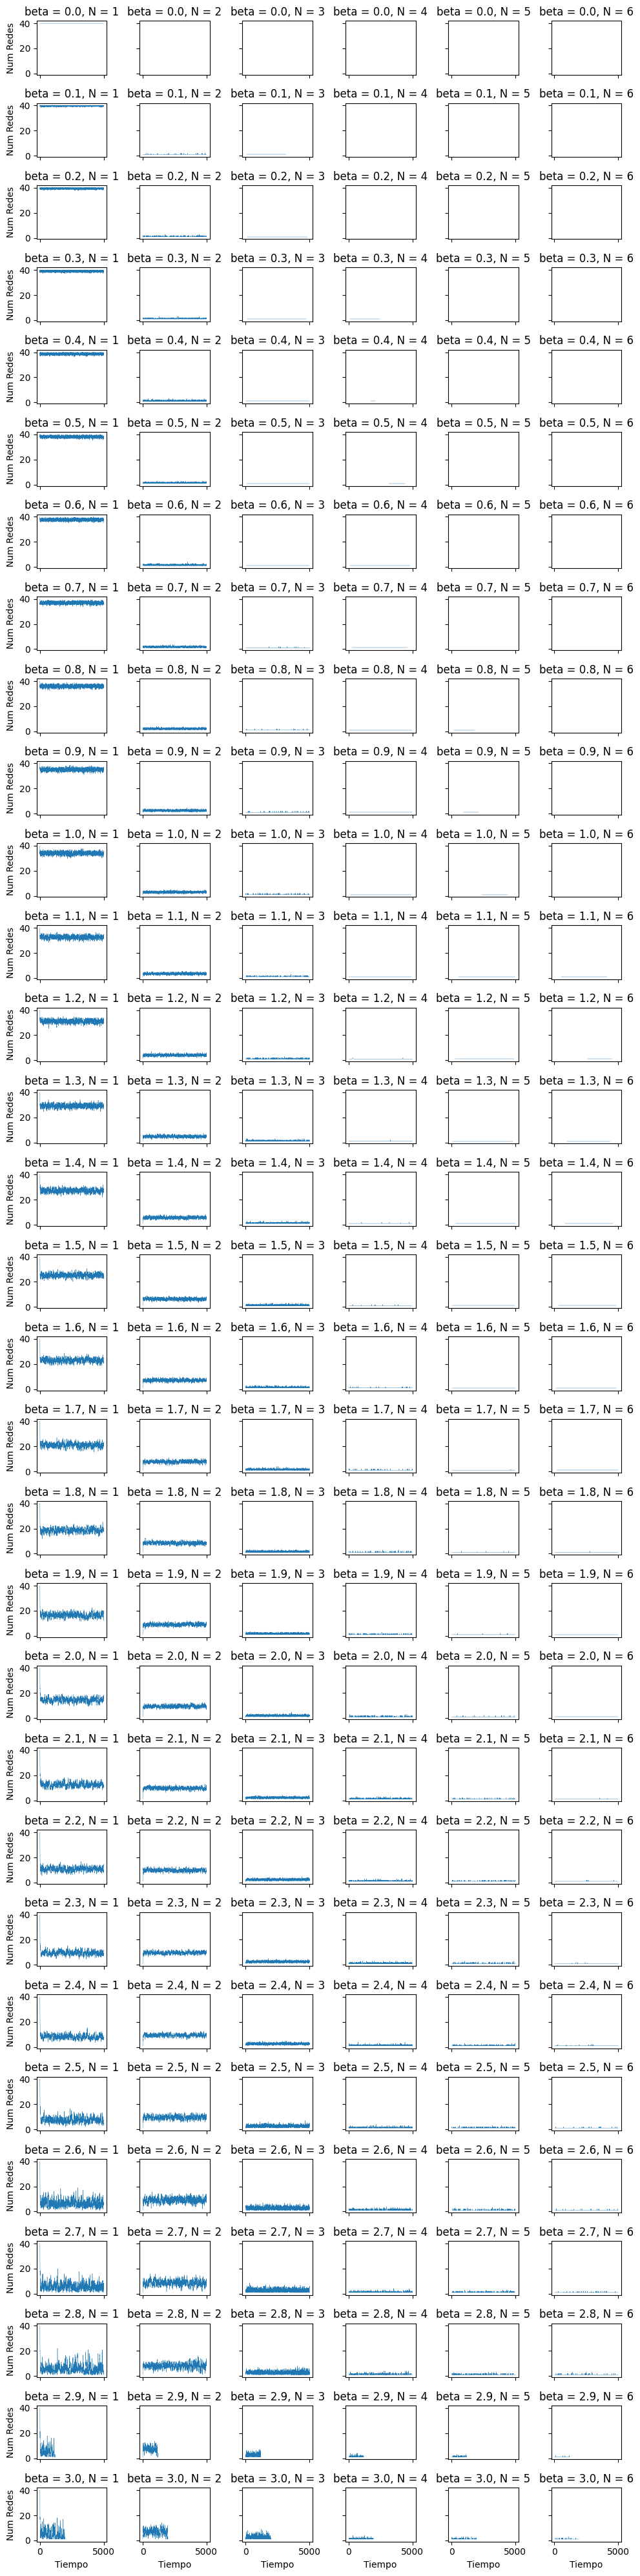

In [62]:
fig, axs = plt.subplots(31,6, sharex='all', sharey='all', figsize=(10,40))

for i, beta in enumerate(sorted(GrMedio_data.keys())):
    for j in range(1,7):
        data = size_abundance[beta]
        data = data.loc[data['N']==j]
        data.plot(x='t',y='NRep', ax=axs[i][j-1], color='tab:blue', legend=False, lw=0.3)
        axs[i][j-1].set_title(f'beta = {beta}, N = {j}')
        axs[i][j-1].set_xlabel('Tiempo')
        axs[i][j-1].set_ylabel('Num Redes')
fig.tight_layout()

***$\beta = 1.2$***

In [17]:
file = '../data/PROCESSED_N40_Beta1.2_TMax5000_Rep1.mat'
sim_data = load_processed_networld(file)
networks = sim_data['Networks_Unique']
networks_time = sim_data['Networks_Time']
networks_time = networks_time.pivot(index='t', columns='NRed', values='NRep')
networks_time = networks_time.fillna(0).reset_index()

network_ids = networks_time.columns[1:]
len(network_ids)

7

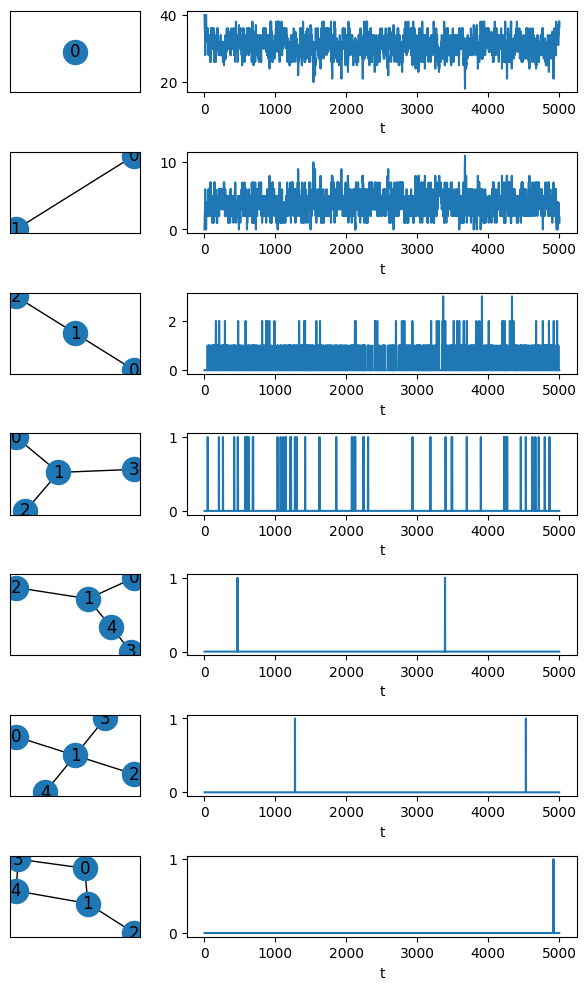

In [18]:
fig, axs = plt.subplots(len(network_ids), 2, figsize=(6,10), gridspec_kw={'width_ratios': [1, 3]})

for id in network_ids:
    G = nx.Graph(networks[int(id)])
    nx.draw_networkx(G, ax=axs[int(id),0], pos=nx.spring_layout(G))
    networks_time.plot(x='t',y=id, legend=False, ax=axs[int(id),1])
fig.tight_layout()

Con beta bajo el crecimiento es tan dificil que las 3 redes básicas ocupan casi el total de la distribución en cualquier punto de tiempo, y solo hay espacio para otra red un poco más grande (aquí 4-5 nodos) que va cambiando entre unas pocas alternativas con el tiempo

***$\beta=2$***

In [63]:
file = '../data/PROCESSED_N40_Beta2_TMax5000_Rep2.mat'
sim_data = load_processed_networld(file)
networks = sim_data['Networks_Unique']
networks_time = sim_data['Networks_Time']
networks_time = networks_time.pivot(index='t', columns='NRed', values='NRep')
networks_time = networks_time.fillna(0).reset_index()

network_ids = networks_time.columns[1:]
len(network_ids)

26

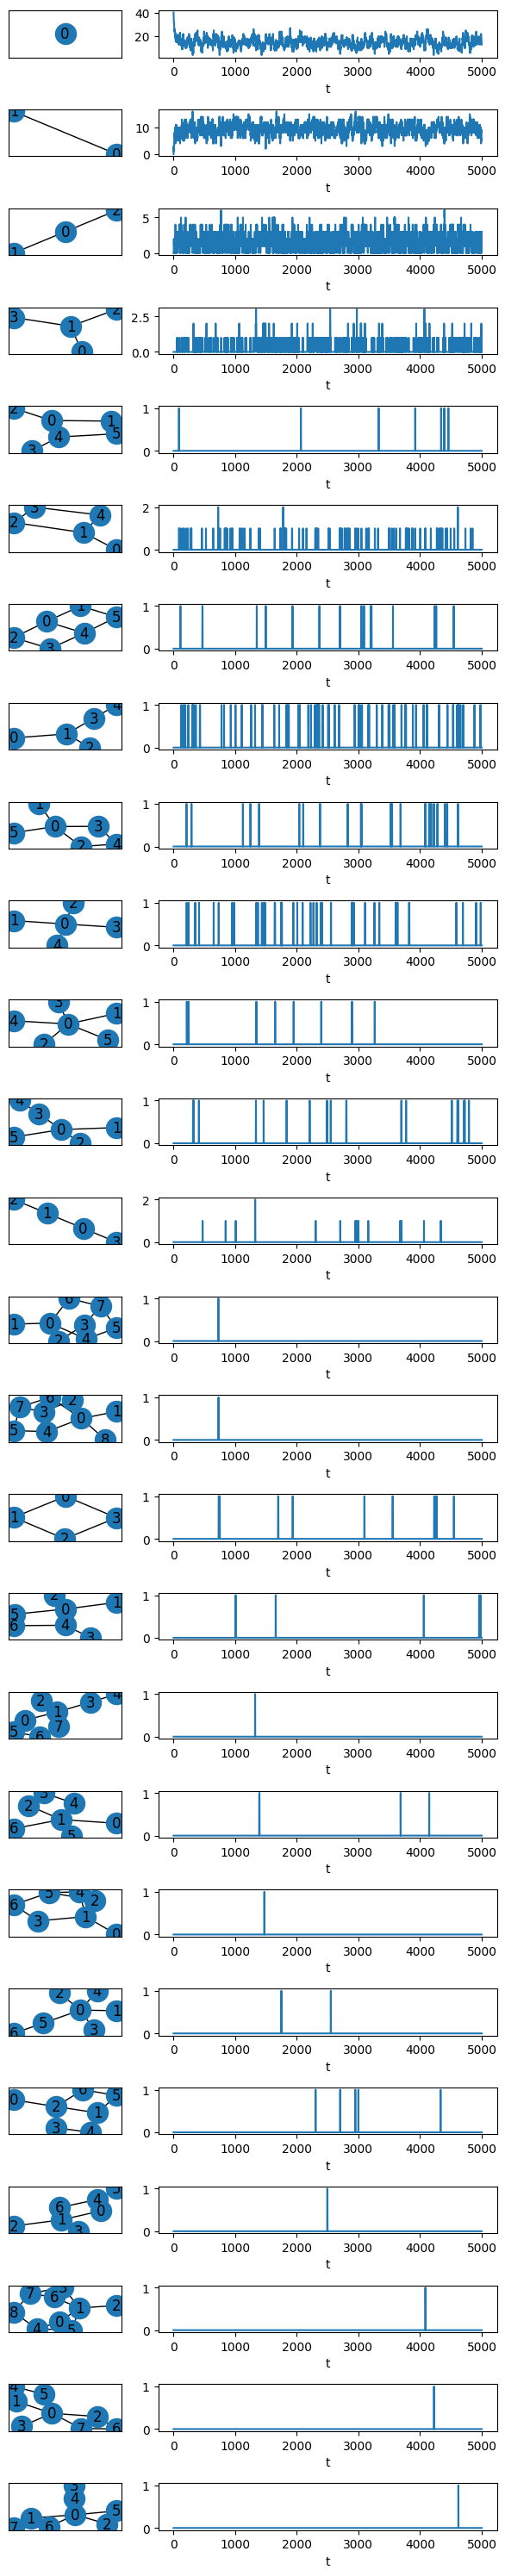

In [64]:
fig, axs = plt.subplots(len(network_ids), 2, figsize=(6,30), gridspec_kw={'width_ratios': [1, 3]})

for id in network_ids:
    G = nx.Graph(networks[int(id)])
    nx.draw_networkx(G, ax=axs[int(id),0], pos=nx.spring_layout(G))
    networks_time.plot(x='t',y=id, legend=False, ax=axs[int(id),1])
fig.tight_layout()

***$\beta = 2.6$***

In [22]:
file = '../data/PROCESSED_N40_Beta2.6_TMax5000_Rep1.mat'
sim_data = load_processed_networld(file)
networks = sim_data['Networks_Unique']
networks_time = sim_data['Networks_Time']
networks_time = networks_time.pivot(index='t', columns='NRed', values='NRep')
networks_time = networks_time.fillna(0).reset_index()

network_ids = networks_time.columns[1:]
len(network_ids)

173

Como esta vez aparecen 173 redes es completamente imposible dibujarlas, vamos a intentar juntar algunas de las menos abundantes en una categoria "otros"

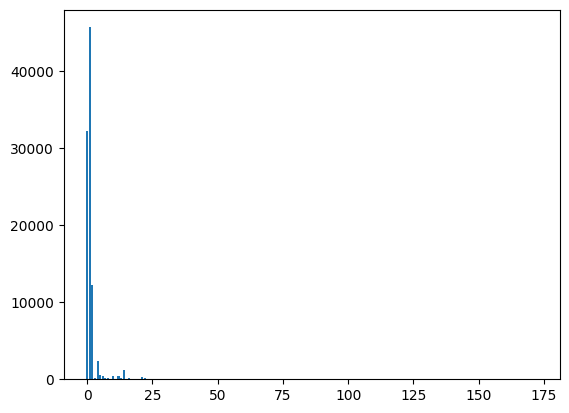

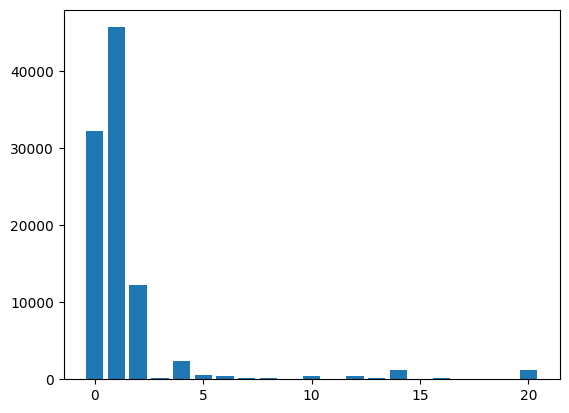

In [23]:
network_occurrences = networks_time[network_ids].sum()
plt.bar(x=network_occurrences.index,height=network_occurrences)
plt.show()

count = sum(network_occurrences[network_ids[network_ids>=20]])
network_occurrences = network_occurrences[network_ids[network_ids<=20]]
network_occurrences[20] = count
plt.bar(x=network_occurrences.index,height=network_occurrences)
plt.show()

La 20 seria el otros

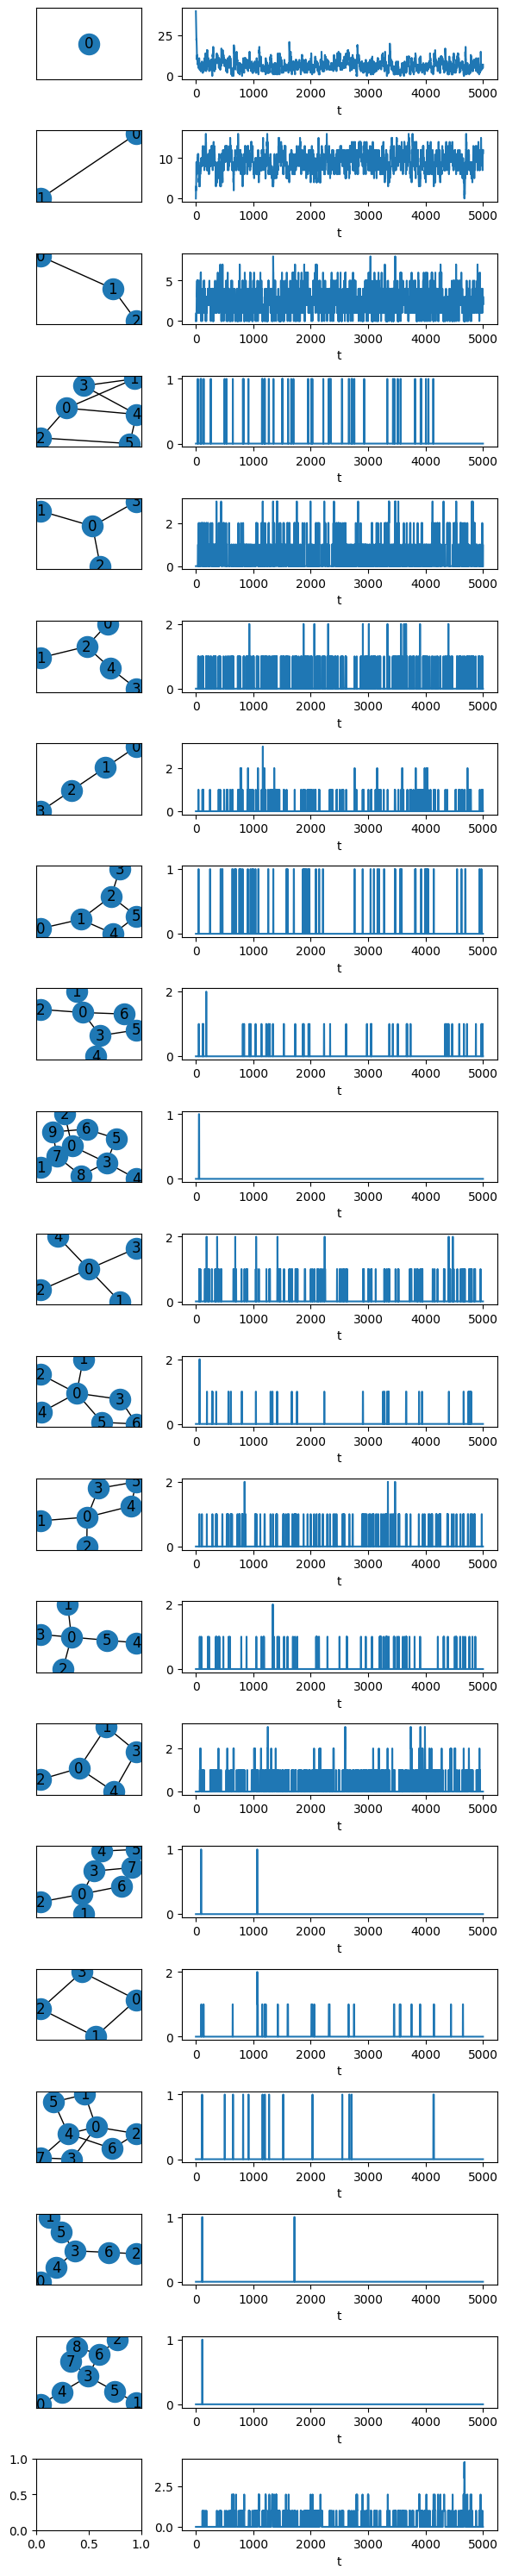

In [24]:
fig, axs = plt.subplots(21, 2, figsize=(6,30), gridspec_kw={'width_ratios': [1, 3]})

for id in range(20):
    G = nx.Graph(networks[int(id)])
    nx.draw_networkx(G, ax=axs[int(id),0], pos=nx.spring_layout(G))
    networks_time.plot(x='t',y=id, legend=False, ax=axs[int(id),1])
networks_time[20] = networks_time[network_ids[network_ids>=20]].sum(axis=1)
networks_time.plot(x='t',y=20, legend=False, ax=axs[20,1])
fig.tight_layout()

In [18]:
import numpy as np
2/(1+np.exp(3.6))

0.05319398715373171

## 3. Stationary Process

***Data loading***

In [3]:
data_path = '../data/'
data_files = []
for file in os.listdir(data_path):
    info = file.split('_')
    if info[1] == 'N40' and info[3] == 'TMax20000':
        data_files.append(file)

In [4]:
data = {}

for file in data_files:
    beta = file.split('_')[2]
    beta = float(beta[4:])
    file = data_path + file
    sim_data = load_processed_networld(file)
    meas_data = sim_data['Networks_Time'].merge(sim_data['Networks_Measures'], how='left', on='NRed')
    if beta in data.keys():
        data[beta].append(meas_data)
    else:
        data[beta] = [meas_data]

***Number of Networks***

In [5]:
num_net_data = {}

for i, beta in enumerate(sorted(data.keys())):
    beta_num_net = []
    for sim_data in data[beta]:
        num_net = sim_data.groupby('t')['NRep'].sum().reset_index()
        beta_num_net.append(num_net)
    num_net_data[beta] = beta_num_net

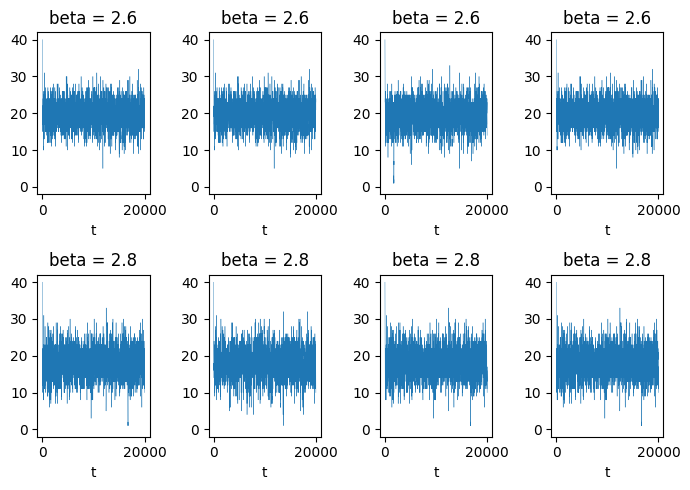

In [47]:
fig, axs = plt.subplots(2, 4, figsize=(7,5))

for i, beta in enumerate(sorted(num_net_data.keys())):
    for j, num_net in enumerate(num_net_data[beta]):
        num_net.plot(x='t', y='NRep', ax=axs[i][j], color='tab:blue', legend=False, lw=0.3)
        axs[i][j].set_title(f'beta = {beta}')
        axs[i][j].set_ylim(-2,42)
fig.tight_layout()

***Diversity of Networks***

Entropía (sin normalizar) de la distribucion de redes que hay en cada instante temporal (X repeticiones de la red 0, Y de la red 1, ...)

In [6]:
diversity_data = {}

for i, beta in enumerate(sorted(data.keys())):
    beta_diversity = []
    for sim_data in data[beta]:
        sim_data['NNet'] = sim_data.groupby('t')['NRep'].transform('sum')
        sim_data['p'] = sim_data['NRep'] / sim_data['NNet']
        diversity = sim_data.groupby('t')['p'].aggregate(entropy).reset_index()
        diversity.rename(columns={'p':'Diversity'}, inplace=True)
        beta_diversity.append(diversity)
    diversity_data[beta] = beta_diversity

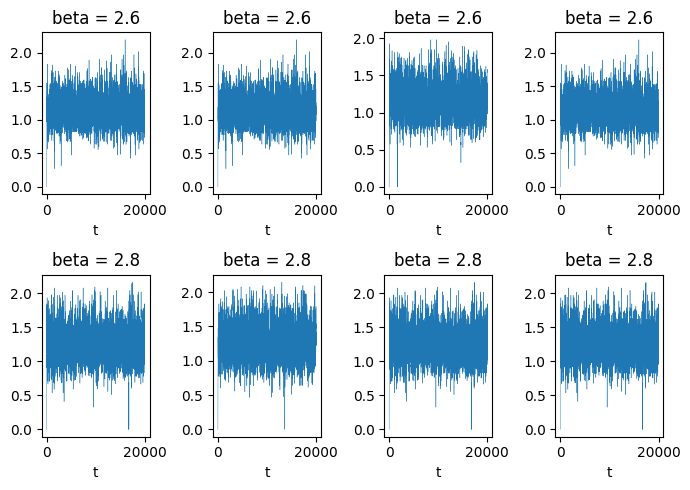

In [49]:
fig, axs = plt.subplots(2,4, figsize=(7,5))

for i, beta in enumerate(sorted(diversity_data.keys())):
    for j, diversity in enumerate(diversity_data[beta]):
        diversity.plot(x='t', y='Diversity', ax=axs[i][j], color='tab:blue', legend=False, lw=0.3)
        axs[i][j].set_title(f'beta = {beta}')
fig.tight_layout()

***$\lambda_1$ of Networks***

In [7]:
lamb1_data = {}

for i, beta in enumerate(sorted(data.keys())):
    beta_lamb1 = []
    for sim_data in data[beta]:
        df_cp = sim_data[['t','NRep','Lamb1','NNet']].copy()
        df_cp['Lamb1'] = df_cp['Lamb1']*df_cp['NRep'] / df_cp['NNet']
        lamb1 = df_cp.groupby('t')['Lamb1'].sum().reset_index()
        beta_lamb1.append(lamb1)
    lamb1_data[beta] = beta_lamb1

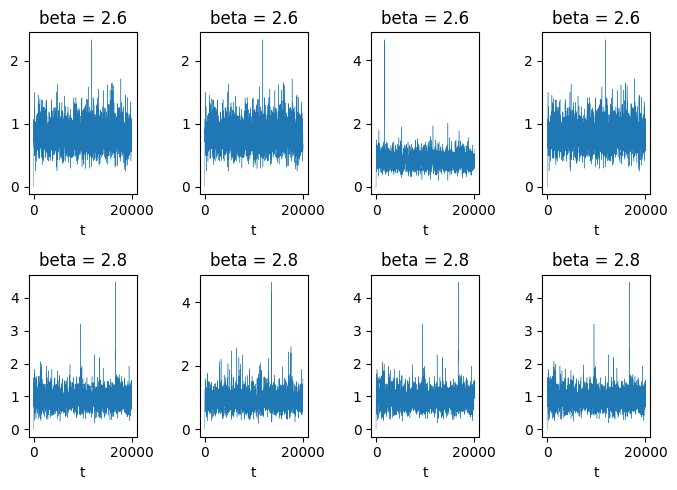

In [51]:
fig, axs = plt.subplots(2,4, figsize=(7,5))

for i, beta in enumerate(sorted(lamb1_data.keys())):
    for j, lamb1 in enumerate(lamb1_data[beta]):
        lamb1.plot(x='t', y='Lamb1', ax=axs[i][j], color='tab:blue', legend=False, lw=0.3)
        axs[i][j].set_title(f'beta = {beta}')
fig.tight_layout()

***$\lambda_2$ of Networks***

In [8]:
lamb2_data = {}

for i, beta in enumerate(sorted(data.keys())):
    beta_lamb2 = []
    for sim_data in data[beta]:
        df_cp = sim_data[['t','NRep','Lamb2','NNet']].copy()
        df_cp['Lamb2'] = df_cp['Lamb2']*df_cp['NRep'] / df_cp['NNet']
        lamb2 = df_cp.groupby('t')['Lamb2'].sum().reset_index()
        beta_lamb2.append(lamb2)
    lamb2_data[beta] = beta_lamb2

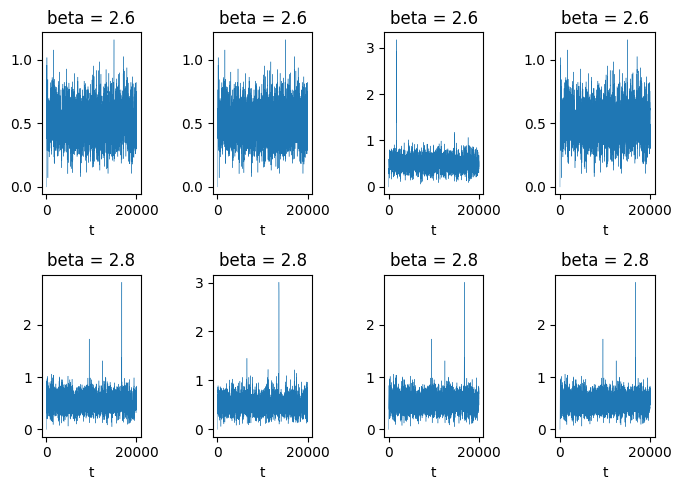

In [53]:
fig, axs = plt.subplots(2,4, figsize=(7,5))

for i, beta in enumerate(sorted(lamb2_data.keys())):
    for j, lamb2 in enumerate(lamb2_data[beta]):
        lamb2.plot(x='t', y='Lamb2', ax=axs[i][j], color='tab:blue', legend=False, lw=0.3)
        axs[i][j].set_title(f'beta = {beta}')
fig.tight_layout()

***H of Networks***

In [9]:
H_data = {}

for i, beta in enumerate(sorted(data.keys())):
    beta_H = []
    for sim_data in data[beta]:
        df_cp = sim_data[['t','NRep','H','NNet']].copy()
        df_cp['H'] = df_cp['H']*df_cp['NRep'] / df_cp['NNet']
        H = df_cp.groupby('t')['H'].sum().reset_index()
        beta_H.append(H)
    H_data[beta] = beta_H

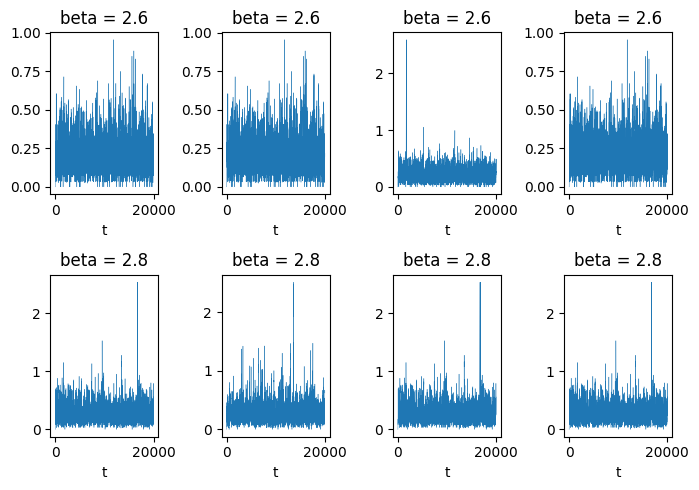

In [55]:
fig, axs = plt.subplots(2,4, figsize=(7,5))

for i, beta in enumerate(sorted(H_data.keys())):
    for j, H in enumerate(H_data[beta]):
        H.plot(x='t', y='H', ax=axs[i][j], color='tab:blue', legend=False, lw=0.3)
        axs[i][j].set_title(f'beta = {beta}')
fig.tight_layout()

***Nº Links of Networks***

In [10]:
N_Links_data = {}

for i, beta in enumerate(sorted(data.keys())):
    beta_N_Links = []
    for sim_data in data[beta]:
        df_cp = sim_data[['t','NRep','GrMedio','NNet', 'N']].copy()
        df_cp['N_Links'] = df_cp['GrMedio'] * df_cp['N']
        df_cp['N_Links'] = df_cp['N_Links'] * df_cp['NRep']
        N_Links = df_cp.groupby('t')['N_Links'].sum().reset_index()
        beta_N_Links.append(N_Links)
    N_Links_data[beta] = beta_N_Links

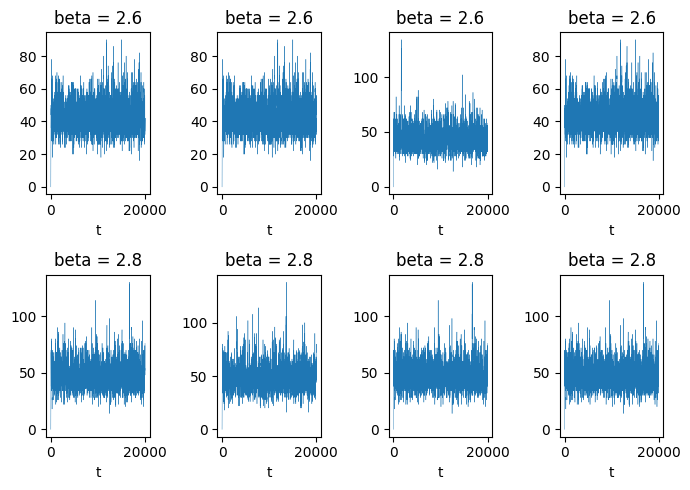

In [57]:
fig, axs = plt.subplots(2,4, figsize=(7,5))

for i, beta in enumerate(sorted(N_Links_data.keys())):
    for j, N_Links in enumerate(N_Links_data[beta]):
        N_Links.plot(x='t', y='N_Links', ax=axs[i][j], color='tab:blue', legend=False, lw=0.3)
        axs[i][j].set_title(f'beta = {beta}')
fig.tight_layout()

IndexError: list index out of range

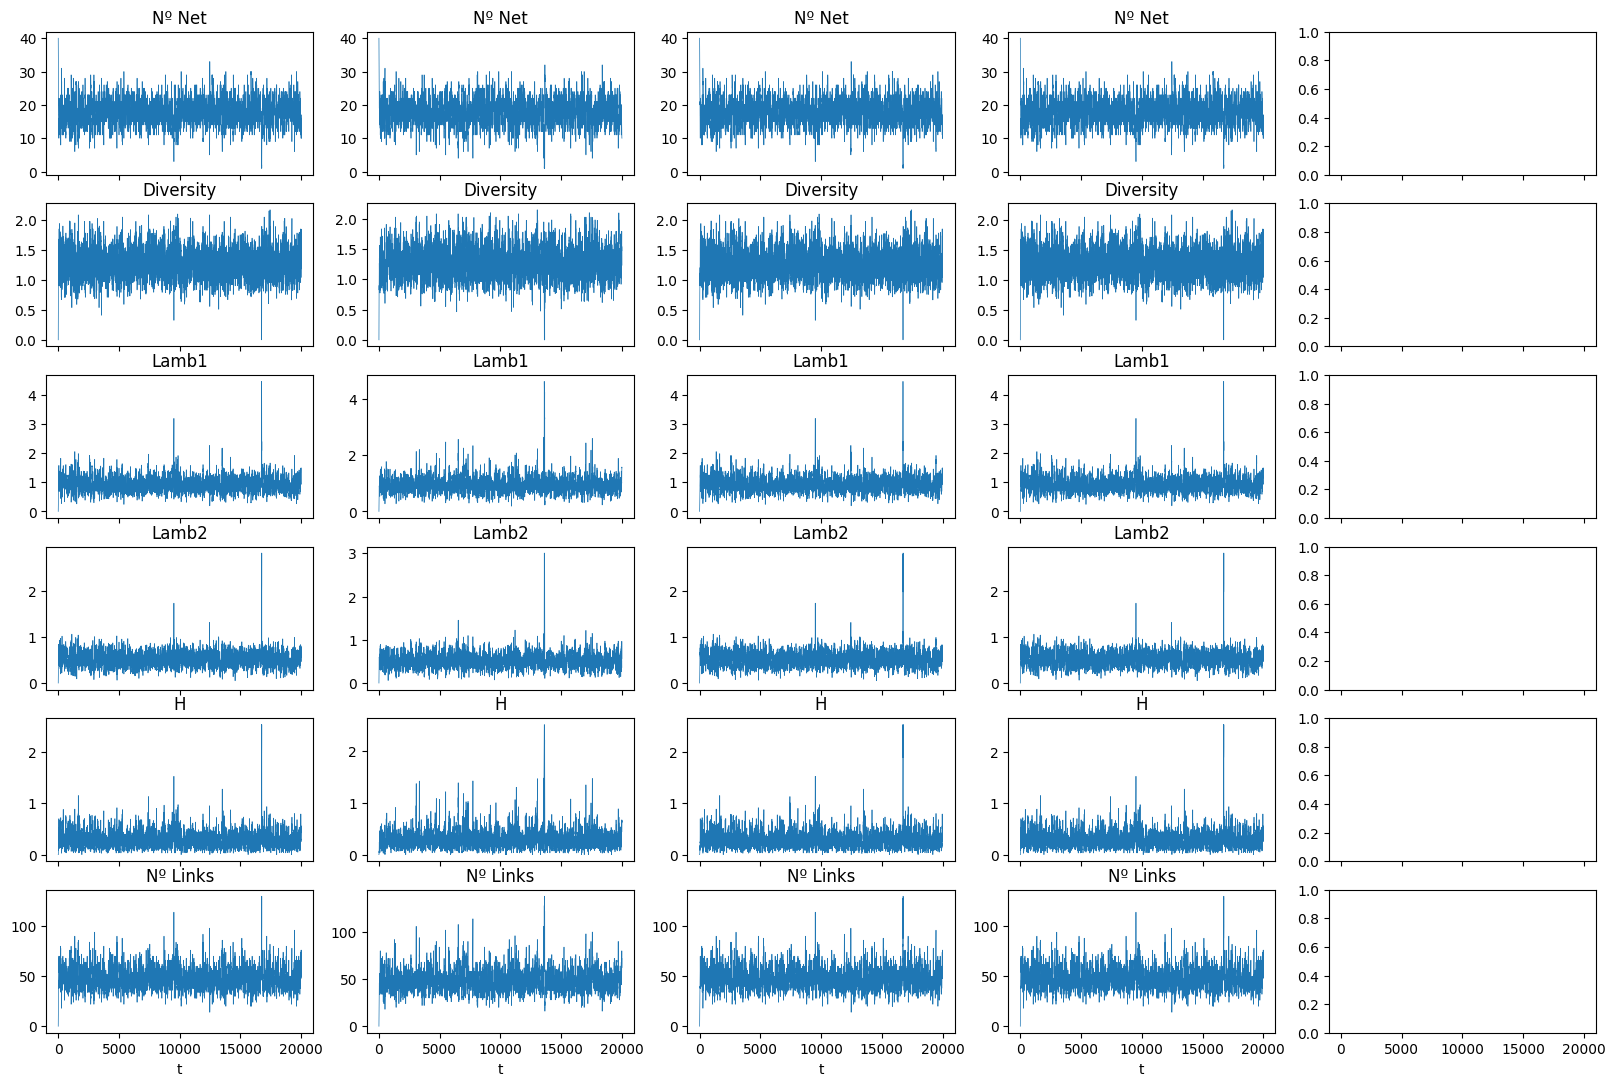

In [11]:
fig, axs = plt.subplots(6,5, figsize=(20,13), sharex=True)

beta = 2.8

for nrep in range(5):
    num_net_data[beta][nrep].plot(x='t', y='NRep', legend=False, ax=axs[0][nrep], lw=0.5)
    axs[0][nrep].set_title(f'Nº Net')
    diversity_data[beta][nrep].plot(x='t', y='Diversity', legend=False, ax=axs[1][nrep], lw=0.5)
    axs[1][nrep].set_title(f'Diversity')
    lamb1_data[beta][nrep].plot(x='t', y='Lamb1', legend=False, ax=axs[2][nrep], lw=0.5)
    axs[2][nrep].set_title(f'Lamb1')
    lamb2_data[beta][nrep].plot(x='t', y='Lamb2', legend=False, ax=axs[3][nrep], lw=0.5)
    axs[3][nrep].set_title(f'Lamb2')
    H_data[beta][nrep].plot(x='t', y='H', legend=False, ax=axs[4][nrep], lw=0.5)
    axs[4][nrep].set_title(f'H')
    N_Links_data[beta][nrep].plot(x='t', y='N_Links', legend=False, ax=axs[5][nrep], lw=0.5)
    axs[5][nrep].set_title(f'Nº Links')
fig.tight_layout()